# Afriat

In [1]:
ood_seed = 10

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["time_cat"] = adata.obs["time_cat"].astype(str).astype(float).astype(int).astype(str).astype("category")
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [7]:
df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
availables = list(df[df>100].index)
availables, len(availables)

([('0', 'Pericentral', 'Control'),
  ('0', 'Periportal', 'Control'),
  ('12', 'Pericentral', 'Infected'),
  ('12', 'Pericentral', 'Uninfected'),
  ('12', 'Periportal', 'Infected'),
  ('12', 'Periportal', 'Uninfected'),
  ('2', 'Pericentral', 'Uninfected'),
  ('2', 'Periportal', 'Infected'),
  ('2', 'Periportal', 'Uninfected'),
  ('24', 'Pericentral', 'Infected'),
  ('24', 'Pericentral', 'Uninfected'),
  ('24', 'Periportal', 'Infected'),
  ('24', 'Periportal', 'Uninfected'),
  ('30', 'Pericentral', 'Infected'),
  ('30', 'Pericentral', 'Uninfected'),
  ('30', 'Periportal', 'Infected'),
  ('30', 'Periportal', 'Uninfected'),
  ('36', 'Pericentral', 'Infected'),
  ('36', 'Pericentral', 'Uninfected'),
  ('36', 'Periportal', 'Infected'),
  ('36', 'Periportal', 'Uninfected')],
 21)

In [8]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

('24', 'Pericentral', 'Uninfected')


Removed datapoint: 1117

train         14342
validation     3594
ood            1117
Name: split, dtype: int64

In [9]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [10]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="time_cat",
    control_group="0",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['zone', 'status_control'],
)

  0%|          | 0/19053 [00:00<?, ?it/s]

 52%|█████▏    | 9825/19053 [00:00<00:00, 98238.15it/s]

100%|██████████| 19053/19053 [00:00<00:00, 98890.83it/s]

  0%|          | 0/19053 [00:00<?, ?it/s]

100%|██████████| 19053/19053 [00:00<00:00, 993832.53it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [11]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [12]:
model.train(max_epochs=400)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 338.32it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:10<1:10:53, 10.66s/it]

Epoch 1/400:   0%|          | 1/400 [00:10<1:10:53, 10.66s/it, v_num=1, recon=4.04e+3, r2_mean=0.181, adv_loss=3.3, acc_pert=0.261, acc_zone=0.758, acc_status_control=0.463]

Epoch 2/400:   0%|          | 1/400 [00:10<1:10:53, 10.66s/it, v_num=1, recon=4.04e+3, r2_mean=0.181, adv_loss=3.3, acc_pert=0.261, acc_zone=0.758, acc_status_control=0.463]

Epoch 2/400:   0%|          | 2/400 [00:20<1:09:00, 10.40s/it, v_num=1, recon=4.04e+3, r2_mean=0.181, adv_loss=3.3, acc_pert=0.261, acc_zone=0.758, acc_status_control=0.463]

Epoch 2/400:   0%|          | 2/400 [00:20<1:09:00, 10.40s/it, v_num=1, recon=3.3e+3, r2_mean=0.601, adv_loss=2.83, acc_pert=0.384, acc_zone=0.839, acc_status_control=0.598]

Epoch 3/400:   0%|          | 2/400 [00:20<1:09:00, 10.40s/it, v_num=1, recon=3.3e+3, r2_mean=0.601, adv_loss=2.83, acc_pert=0.384, acc_zone=0.839, acc_status_control=0.598]

Epoch 3/400:   1%|          | 3/400 [00:31<1:08:01, 10.28s/it, v_num=1, recon=3.3e+3, r2_mean=0.601, adv_loss=2.83, acc_pert=0.384, acc_zone=0.839, acc_status_control=0.598]

Epoch 3/400:   1%|          | 3/400 [00:31<1:08:01, 10.28s/it, v_num=1, recon=3.24e+3, r2_mean=0.707, adv_loss=2.71, acc_pert=0.4, acc_zone=0.847, acc_status_control=0.611] 

Epoch 4/400:   1%|          | 3/400 [00:31<1:08:01, 10.28s/it, v_num=1, recon=3.24e+3, r2_mean=0.707, adv_loss=2.71, acc_pert=0.4, acc_zone=0.847, acc_status_control=0.611]

Epoch 4/400:   1%|          | 4/400 [00:42<1:09:45, 10.57s/it, v_num=1, recon=3.24e+3, r2_mean=0.707, adv_loss=2.71, acc_pert=0.4, acc_zone=0.847, acc_status_control=0.611]

Epoch 4/400:   1%|          | 4/400 [00:42<1:09:45, 10.57s/it, v_num=1, recon=3.21e+3, r2_mean=0.744, adv_loss=2.65, acc_pert=0.444, acc_zone=0.843, acc_status_control=0.605]

Epoch 5/400:   1%|          | 4/400 [00:42<1:09:45, 10.57s/it, v_num=1, recon=3.21e+3, r2_mean=0.744, adv_loss=2.65, acc_pert=0.444, acc_zone=0.843, acc_status_control=0.605]

Epoch 5/400:   1%|▏         | 5/400 [00:52<1:08:25, 10.39s/it, v_num=1, recon=3.21e+3, r2_mean=0.744, adv_loss=2.65, acc_pert=0.444, acc_zone=0.843, acc_status_control=0.605]

Epoch 5/400:   1%|▏         | 5/400 [00:52<1:08:25, 10.39s/it, v_num=1, recon=3.21e+3, r2_mean=0.767, adv_loss=2.46, acc_pert=0.513, acc_zone=0.845, acc_status_control=0.6]  

Epoch 6/400:   1%|▏         | 5/400 [00:52<1:08:25, 10.39s/it, v_num=1, recon=3.21e+3, r2_mean=0.767, adv_loss=2.46, acc_pert=0.513, acc_zone=0.845, acc_status_control=0.6]

Epoch 6/400:   2%|▏         | 6/400 [01:02<1:07:50, 10.33s/it, v_num=1, recon=3.21e+3, r2_mean=0.767, adv_loss=2.46, acc_pert=0.513, acc_zone=0.845, acc_status_control=0.6]

Epoch 6/400:   2%|▏         | 6/400 [01:02<1:07:50, 10.33s/it, v_num=1, recon=3.2e+3, r2_mean=0.778, adv_loss=2.34, acc_pert=0.548, acc_zone=0.847, acc_status_control=0.591]

Epoch 7/400:   2%|▏         | 6/400 [01:02<1:07:50, 10.33s/it, v_num=1, recon=3.2e+3, r2_mean=0.778, adv_loss=2.34, acc_pert=0.548, acc_zone=0.847, acc_status_control=0.591]

Epoch 7/400:   2%|▏         | 7/400 [01:12<1:07:14, 10.27s/it, v_num=1, recon=3.2e+3, r2_mean=0.778, adv_loss=2.34, acc_pert=0.548, acc_zone=0.847, acc_status_control=0.591]

Epoch 7/400:   2%|▏         | 7/400 [01:12<1:07:14, 10.27s/it, v_num=1, recon=3.19e+3, r2_mean=0.794, adv_loss=2.24, acc_pert=0.578, acc_zone=0.852, acc_status_control=0.605]

Epoch 8/400:   2%|▏         | 7/400 [01:12<1:07:14, 10.27s/it, v_num=1, recon=3.19e+3, r2_mean=0.794, adv_loss=2.24, acc_pert=0.578, acc_zone=0.852, acc_status_control=0.605]

Epoch 8/400:   2%|▏         | 8/400 [01:22<1:06:50, 10.23s/it, v_num=1, recon=3.19e+3, r2_mean=0.794, adv_loss=2.24, acc_pert=0.578, acc_zone=0.852, acc_status_control=0.605]

Epoch 8/400:   2%|▏         | 8/400 [01:22<1:06:50, 10.23s/it, v_num=1, recon=3.17e+3, r2_mean=0.799, adv_loss=2.16, acc_pert=0.605, acc_zone=0.857, acc_status_control=0.607]

Epoch 9/400:   2%|▏         | 8/400 [01:22<1:06:50, 10.23s/it, v_num=1, recon=3.17e+3, r2_mean=0.799, adv_loss=2.16, acc_pert=0.605, acc_zone=0.857, acc_status_control=0.607]

Epoch 9/400:   2%|▏         | 9/400 [01:32<1:06:24, 10.19s/it, v_num=1, recon=3.17e+3, r2_mean=0.799, adv_loss=2.16, acc_pert=0.605, acc_zone=0.857, acc_status_control=0.607]

Epoch 9/400:   2%|▏         | 9/400 [01:32<1:06:24, 10.19s/it, v_num=1, recon=3.17e+3, r2_mean=0.803, adv_loss=2.1, acc_pert=0.627, acc_zone=0.861, acc_status_control=0.61]  

Epoch 10/400:   2%|▏         | 9/400 [01:32<1:06:24, 10.19s/it, v_num=1, recon=3.17e+3, r2_mean=0.803, adv_loss=2.1, acc_pert=0.627, acc_zone=0.861, acc_status_control=0.61]


disnt_basal = 1.222462279707114

disnt_after = 1.864342406587572

val_r2_mean = 0.7974615557904962

val_r2_var = 0.1773337005904504


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [01:56<1:34:02, 14.47s/it, v_num=1, recon=3.17e+3, r2_mean=0.803, adv_loss=2.1, acc_pert=0.627, acc_zone=0.861, acc_status_control=0.61]

Epoch 10/400:   2%|▎         | 10/400 [01:56<1:34:02, 14.47s/it, v_num=1, recon=3.15e+3, r2_mean=0.807, adv_loss=2.1, acc_pert=0.632, acc_zone=0.861, acc_status_control=0.612, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.797, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [01:56<1:34:02, 14.47s/it, v_num=1, recon=3.15e+3, r2_mean=0.807, adv_loss=2.1, acc_pert=0.632, acc_zone=0.861, acc_status_control=0.612, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.797, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [02:07<1:25:54, 13.25s/it, v_num=1, recon=3.15e+3, r2_mean=0.807, adv_loss=2.1, acc_pert=0.632, acc_zone=0.861, acc_status_control=0.612, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.797, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [02:07<1:25:54, 13.25s/it, v_num=1, recon=3.15e+3, r2_mean=0.812, adv_loss=2.06, acc_pert=0.651, acc_zone=0.861, acc_status_control=0.616, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.797, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [02:07<1:25:54, 13.25s/it, v_num=1, recon=3.15e+3, r2_mean=0.812, adv_loss=2.06, acc_pert=0.651, acc_zone=0.861, acc_status_control=0.616, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.797, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [02:17<1:20:35, 12.46s/it, v_num=1, recon=3.15e+3, r2_mean=0.812, adv_loss=2.06, acc_pert=0.651, acc_zone=0.861, acc_status_control=0.616, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.797, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [02:17<1:20:35, 12.46s/it, v_num=1, recon=3.14e+3, r2_mean=0.815, adv_loss=1.99, acc_pert=0.666, acc_zone=0.865, acc_status_control=0.622, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.797, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [02:17<1:20:35, 12.46s/it, v_num=1, recon=3.14e+3, r2_mean=0.815, adv_loss=1.99, acc_pert=0.666, acc_zone=0.865, acc_status_control=0.622, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.797, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [02:28<1:15:48, 11.75s/it, v_num=1, recon=3.14e+3, r2_mean=0.815, adv_loss=1.99, acc_pert=0.666, acc_zone=0.865, acc_status_control=0.622, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.797, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [02:28<1:15:48, 11.75s/it, v_num=1, recon=3.15e+3, r2_mean=0.817, adv_loss=1.98, acc_pert=0.665, acc_zone=0.863, acc_status_control=0.619, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.797, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [02:28<1:15:48, 11.75s/it, v_num=1, recon=3.15e+3, r2_mean=0.817, adv_loss=1.98, acc_pert=0.665, acc_zone=0.863, acc_status_control=0.619, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.797, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:38<1:12:29, 11.27s/it, v_num=1, recon=3.15e+3, r2_mean=0.817, adv_loss=1.98, acc_pert=0.665, acc_zone=0.863, acc_status_control=0.619, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.797, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:38<1:12:29, 11.27s/it, v_num=1, recon=3.14e+3, r2_mean=0.818, adv_loss=1.98, acc_pert=0.667, acc_zone=0.861, acc_status_control=0.625, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.797, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [02:38<1:12:29, 11.27s/it, v_num=1, recon=3.14e+3, r2_mean=0.818, adv_loss=1.98, acc_pert=0.667, acc_zone=0.861, acc_status_control=0.625, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.797, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:48<1:09:52, 10.89s/it, v_num=1, recon=3.14e+3, r2_mean=0.818, adv_loss=1.98, acc_pert=0.667, acc_zone=0.861, acc_status_control=0.625, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.797, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:48<1:09:52, 10.89s/it, v_num=1, recon=3.14e+3, r2_mean=0.822, adv_loss=2, acc_pert=0.671, acc_zone=0.862, acc_status_control=0.621, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.797, val_KL=nan]   

Epoch 16/400:   4%|▍         | 15/400 [02:48<1:09:52, 10.89s/it, v_num=1, recon=3.14e+3, r2_mean=0.822, adv_loss=2, acc_pert=0.671, acc_zone=0.862, acc_status_control=0.621, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.797, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [02:58<1:08:17, 10.67s/it, v_num=1, recon=3.14e+3, r2_mean=0.822, adv_loss=2, acc_pert=0.671, acc_zone=0.862, acc_status_control=0.621, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.797, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [02:58<1:08:17, 10.67s/it, v_num=1, recon=3.12e+3, r2_mean=0.818, adv_loss=1.97, acc_pert=0.675, acc_zone=0.865, acc_status_control=0.626, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.797, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [02:58<1:08:17, 10.67s/it, v_num=1, recon=3.12e+3, r2_mean=0.818, adv_loss=1.97, acc_pert=0.675, acc_zone=0.865, acc_status_control=0.626, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.797, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [03:08<1:07:00, 10.50s/it, v_num=1, recon=3.12e+3, r2_mean=0.818, adv_loss=1.97, acc_pert=0.675, acc_zone=0.865, acc_status_control=0.626, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.797, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [03:08<1:07:00, 10.50s/it, v_num=1, recon=3.12e+3, r2_mean=0.824, adv_loss=1.95, acc_pert=0.679, acc_zone=0.866, acc_status_control=0.636, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.797, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [03:08<1:07:00, 10.50s/it, v_num=1, recon=3.12e+3, r2_mean=0.824, adv_loss=1.95, acc_pert=0.679, acc_zone=0.866, acc_status_control=0.636, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.797, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [03:18<1:06:09, 10.39s/it, v_num=1, recon=3.12e+3, r2_mean=0.824, adv_loss=1.95, acc_pert=0.679, acc_zone=0.866, acc_status_control=0.636, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.797, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [03:18<1:06:09, 10.39s/it, v_num=1, recon=3.12e+3, r2_mean=0.824, adv_loss=1.94, acc_pert=0.683, acc_zone=0.861, acc_status_control=0.638, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.797, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [03:18<1:06:09, 10.39s/it, v_num=1, recon=3.12e+3, r2_mean=0.824, adv_loss=1.94, acc_pert=0.683, acc_zone=0.861, acc_status_control=0.638, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.797, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [03:29<1:06:14, 10.43s/it, v_num=1, recon=3.12e+3, r2_mean=0.824, adv_loss=1.94, acc_pert=0.683, acc_zone=0.861, acc_status_control=0.638, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.797, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [03:29<1:06:14, 10.43s/it, v_num=1, recon=3.12e+3, r2_mean=0.822, adv_loss=1.93, acc_pert=0.674, acc_zone=0.865, acc_status_control=0.639, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.797, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [03:29<1:06:14, 10.43s/it, v_num=1, recon=3.12e+3, r2_mean=0.822, adv_loss=1.93, acc_pert=0.674, acc_zone=0.865, acc_status_control=0.639, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.797, val_KL=nan]


disnt_basal = 1.2043000678556477

disnt_after = 1.8449277621559264

val_r2_mean = 0.8138296155920555

val_r2_var = 0.2212357672054469


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [03:58<1:41:25, 16.02s/it, v_num=1, recon=3.12e+3, r2_mean=0.822, adv_loss=1.93, acc_pert=0.674, acc_zone=0.865, acc_status_control=0.639, val_recon=3.12e+3, disnt_basal=1.22, disnt_after=1.86, val_r2_mean=0.797, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [03:58<1:41:25, 16.02s/it, v_num=1, recon=3.11e+3, r2_mean=0.823, adv_loss=1.93, acc_pert=0.679, acc_zone=0.865, acc_status_control=0.637, val_recon=3.08e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.814, val_KL=nan] 

Epoch 21/400:   5%|▌         | 20/400 [03:58<1:41:25, 16.02s/it, v_num=1, recon=3.11e+3, r2_mean=0.823, adv_loss=1.93, acc_pert=0.679, acc_zone=0.865, acc_status_control=0.637, val_recon=3.08e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.814, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [04:09<1:31:49, 14.54s/it, v_num=1, recon=3.11e+3, r2_mean=0.823, adv_loss=1.93, acc_pert=0.679, acc_zone=0.865, acc_status_control=0.637, val_recon=3.08e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.814, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [04:09<1:31:49, 14.54s/it, v_num=1, recon=3.1e+3, r2_mean=0.824, adv_loss=1.92, acc_pert=0.684, acc_zone=0.86, acc_status_control=0.641, val_recon=3.08e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.814, val_KL=nan]  

Epoch 22/400:   5%|▌         | 21/400 [04:09<1:31:49, 14.54s/it, v_num=1, recon=3.1e+3, r2_mean=0.824, adv_loss=1.92, acc_pert=0.684, acc_zone=0.86, acc_status_control=0.641, val_recon=3.08e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.814, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [04:19<1:23:43, 13.29s/it, v_num=1, recon=3.1e+3, r2_mean=0.824, adv_loss=1.92, acc_pert=0.684, acc_zone=0.86, acc_status_control=0.641, val_recon=3.08e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.814, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [04:19<1:23:43, 13.29s/it, v_num=1, recon=3.1e+3, r2_mean=0.827, adv_loss=1.92, acc_pert=0.683, acc_zone=0.864, acc_status_control=0.642, val_recon=3.08e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.814, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [04:19<1:23:43, 13.29s/it, v_num=1, recon=3.1e+3, r2_mean=0.827, adv_loss=1.92, acc_pert=0.683, acc_zone=0.864, acc_status_control=0.642, val_recon=3.08e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.814, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [04:30<1:18:20, 12.47s/it, v_num=1, recon=3.1e+3, r2_mean=0.827, adv_loss=1.92, acc_pert=0.683, acc_zone=0.864, acc_status_control=0.642, val_recon=3.08e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.814, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [04:30<1:18:20, 12.47s/it, v_num=1, recon=3.1e+3, r2_mean=0.829, adv_loss=1.94, acc_pert=0.674, acc_zone=0.862, acc_status_control=0.636, val_recon=3.08e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.814, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [04:30<1:18:20, 12.47s/it, v_num=1, recon=3.1e+3, r2_mean=0.829, adv_loss=1.94, acc_pert=0.674, acc_zone=0.862, acc_status_control=0.636, val_recon=3.08e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.814, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [04:40<1:13:49, 11.78s/it, v_num=1, recon=3.1e+3, r2_mean=0.829, adv_loss=1.94, acc_pert=0.674, acc_zone=0.862, acc_status_control=0.636, val_recon=3.08e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.814, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [04:40<1:13:49, 11.78s/it, v_num=1, recon=3.09e+3, r2_mean=0.824, adv_loss=1.92, acc_pert=0.672, acc_zone=0.861, acc_status_control=0.646, val_recon=3.08e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.814, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [04:40<1:13:49, 11.78s/it, v_num=1, recon=3.09e+3, r2_mean=0.824, adv_loss=1.92, acc_pert=0.672, acc_zone=0.861, acc_status_control=0.646, val_recon=3.08e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.814, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [04:50<1:10:26, 11.27s/it, v_num=1, recon=3.09e+3, r2_mean=0.824, adv_loss=1.92, acc_pert=0.672, acc_zone=0.861, acc_status_control=0.646, val_recon=3.08e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.814, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [04:50<1:10:26, 11.27s/it, v_num=1, recon=3.1e+3, r2_mean=0.826, adv_loss=1.9, acc_pert=0.688, acc_zone=0.857, acc_status_control=0.642, val_recon=3.08e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.814, val_KL=nan]  

Epoch 26/400:   6%|▋         | 25/400 [04:50<1:10:26, 11.27s/it, v_num=1, recon=3.1e+3, r2_mean=0.826, adv_loss=1.9, acc_pert=0.688, acc_zone=0.857, acc_status_control=0.642, val_recon=3.08e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.814, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [05:01<1:10:26, 11.30s/it, v_num=1, recon=3.1e+3, r2_mean=0.826, adv_loss=1.9, acc_pert=0.688, acc_zone=0.857, acc_status_control=0.642, val_recon=3.08e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.814, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [05:01<1:10:26, 11.30s/it, v_num=1, recon=3.09e+3, r2_mean=0.827, adv_loss=1.91, acc_pert=0.685, acc_zone=0.862, acc_status_control=0.652, val_recon=3.08e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.814, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [05:01<1:10:26, 11.30s/it, v_num=1, recon=3.09e+3, r2_mean=0.827, adv_loss=1.91, acc_pert=0.685, acc_zone=0.862, acc_status_control=0.652, val_recon=3.08e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.814, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [05:12<1:09:27, 11.17s/it, v_num=1, recon=3.09e+3, r2_mean=0.827, adv_loss=1.91, acc_pert=0.685, acc_zone=0.862, acc_status_control=0.652, val_recon=3.08e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.814, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [05:12<1:09:27, 11.17s/it, v_num=1, recon=3.1e+3, r2_mean=0.829, adv_loss=1.92, acc_pert=0.685, acc_zone=0.857, acc_status_control=0.646, val_recon=3.08e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.814, val_KL=nan] 

Epoch 28/400:   7%|▋         | 27/400 [05:12<1:09:27, 11.17s/it, v_num=1, recon=3.1e+3, r2_mean=0.829, adv_loss=1.92, acc_pert=0.685, acc_zone=0.857, acc_status_control=0.646, val_recon=3.08e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.814, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [05:23<1:09:27, 11.20s/it, v_num=1, recon=3.1e+3, r2_mean=0.829, adv_loss=1.92, acc_pert=0.685, acc_zone=0.857, acc_status_control=0.646, val_recon=3.08e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.814, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [05:23<1:09:27, 11.20s/it, v_num=1, recon=3.09e+3, r2_mean=0.828, adv_loss=1.91, acc_pert=0.685, acc_zone=0.858, acc_status_control=0.645, val_recon=3.08e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.814, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [05:23<1:09:27, 11.20s/it, v_num=1, recon=3.09e+3, r2_mean=0.828, adv_loss=1.91, acc_pert=0.685, acc_zone=0.858, acc_status_control=0.645, val_recon=3.08e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.814, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [05:35<1:09:57, 11.31s/it, v_num=1, recon=3.09e+3, r2_mean=0.828, adv_loss=1.91, acc_pert=0.685, acc_zone=0.858, acc_status_control=0.645, val_recon=3.08e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.814, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [05:35<1:09:57, 11.31s/it, v_num=1, recon=3.09e+3, r2_mean=0.83, adv_loss=1.91, acc_pert=0.683, acc_zone=0.861, acc_status_control=0.649, val_recon=3.08e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.814, val_KL=nan] 

Epoch 30/400:   7%|▋         | 29/400 [05:35<1:09:57, 11.31s/it, v_num=1, recon=3.09e+3, r2_mean=0.83, adv_loss=1.91, acc_pert=0.683, acc_zone=0.861, acc_status_control=0.649, val_recon=3.08e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.814, val_KL=nan]


disnt_basal = 1.1995342990134221

disnt_after = 1.8425034232444675

val_r2_mean = 0.8149784899404653

val_r2_var = 0.23786791734054716


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [06:03<1:41:07, 16.40s/it, v_num=1, recon=3.09e+3, r2_mean=0.83, adv_loss=1.91, acc_pert=0.683, acc_zone=0.861, acc_status_control=0.649, val_recon=3.08e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.814, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [06:03<1:41:07, 16.40s/it, v_num=1, recon=3.08e+3, r2_mean=0.829, adv_loss=1.92, acc_pert=0.684, acc_zone=0.858, acc_status_control=0.649, val_recon=3.05e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.815, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [06:03<1:41:07, 16.40s/it, v_num=1, recon=3.08e+3, r2_mean=0.829, adv_loss=1.92, acc_pert=0.684, acc_zone=0.858, acc_status_control=0.649, val_recon=3.05e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.815, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [06:14<1:29:33, 14.56s/it, v_num=1, recon=3.08e+3, r2_mean=0.829, adv_loss=1.92, acc_pert=0.684, acc_zone=0.858, acc_status_control=0.649, val_recon=3.05e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.815, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [06:14<1:29:33, 14.56s/it, v_num=1, recon=3.08e+3, r2_mean=0.829, adv_loss=1.93, acc_pert=0.682, acc_zone=0.855, acc_status_control=0.647, val_recon=3.05e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.815, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [06:14<1:29:33, 14.56s/it, v_num=1, recon=3.08e+3, r2_mean=0.829, adv_loss=1.93, acc_pert=0.682, acc_zone=0.855, acc_status_control=0.647, val_recon=3.05e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.815, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [06:24<1:21:05, 13.22s/it, v_num=1, recon=3.08e+3, r2_mean=0.829, adv_loss=1.93, acc_pert=0.682, acc_zone=0.855, acc_status_control=0.647, val_recon=3.05e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.815, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [06:24<1:21:05, 13.22s/it, v_num=1, recon=3.08e+3, r2_mean=0.829, adv_loss=1.94, acc_pert=0.677, acc_zone=0.859, acc_status_control=0.642, val_recon=3.05e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.815, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [06:24<1:21:05, 13.22s/it, v_num=1, recon=3.08e+3, r2_mean=0.829, adv_loss=1.94, acc_pert=0.677, acc_zone=0.859, acc_status_control=0.642, val_recon=3.05e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.815, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [06:34<1:15:23, 12.32s/it, v_num=1, recon=3.08e+3, r2_mean=0.829, adv_loss=1.94, acc_pert=0.677, acc_zone=0.859, acc_status_control=0.642, val_recon=3.05e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.815, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [06:34<1:15:23, 12.32s/it, v_num=1, recon=3.07e+3, r2_mean=0.83, adv_loss=1.94, acc_pert=0.678, acc_zone=0.86, acc_status_control=0.644, val_recon=3.05e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.815, val_KL=nan]  

Epoch 34/400:   8%|▊         | 33/400 [06:34<1:15:23, 12.32s/it, v_num=1, recon=3.07e+3, r2_mean=0.83, adv_loss=1.94, acc_pert=0.678, acc_zone=0.86, acc_status_control=0.644, val_recon=3.05e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.815, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [06:44<1:11:06, 11.66s/it, v_num=1, recon=3.07e+3, r2_mean=0.83, adv_loss=1.94, acc_pert=0.678, acc_zone=0.86, acc_status_control=0.644, val_recon=3.05e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.815, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [06:44<1:11:06, 11.66s/it, v_num=1, recon=3.07e+3, r2_mean=0.83, adv_loss=1.94, acc_pert=0.679, acc_zone=0.858, acc_status_control=0.649, val_recon=3.05e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.815, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [06:44<1:11:06, 11.66s/it, v_num=1, recon=3.07e+3, r2_mean=0.83, adv_loss=1.94, acc_pert=0.679, acc_zone=0.858, acc_status_control=0.649, val_recon=3.05e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.815, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [06:55<1:09:53, 11.49s/it, v_num=1, recon=3.07e+3, r2_mean=0.83, adv_loss=1.94, acc_pert=0.679, acc_zone=0.858, acc_status_control=0.649, val_recon=3.05e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.815, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [06:55<1:09:53, 11.49s/it, v_num=1, recon=3.06e+3, r2_mean=0.83, adv_loss=1.95, acc_pert=0.674, acc_zone=0.857, acc_status_control=0.643, val_recon=3.05e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.815, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [06:55<1:09:53, 11.49s/it, v_num=1, recon=3.06e+3, r2_mean=0.83, adv_loss=1.95, acc_pert=0.674, acc_zone=0.857, acc_status_control=0.643, val_recon=3.05e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.815, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [07:06<1:09:31, 11.46s/it, v_num=1, recon=3.06e+3, r2_mean=0.83, adv_loss=1.95, acc_pert=0.674, acc_zone=0.857, acc_status_control=0.643, val_recon=3.05e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.815, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [07:06<1:09:31, 11.46s/it, v_num=1, recon=3.06e+3, r2_mean=0.829, adv_loss=1.96, acc_pert=0.673, acc_zone=0.854, acc_status_control=0.647, val_recon=3.05e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.815, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [07:06<1:09:31, 11.46s/it, v_num=1, recon=3.06e+3, r2_mean=0.829, adv_loss=1.96, acc_pert=0.673, acc_zone=0.854, acc_status_control=0.647, val_recon=3.05e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.815, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [07:17<1:07:39, 11.18s/it, v_num=1, recon=3.06e+3, r2_mean=0.829, adv_loss=1.96, acc_pert=0.673, acc_zone=0.854, acc_status_control=0.647, val_recon=3.05e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.815, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [07:17<1:07:39, 11.18s/it, v_num=1, recon=3.06e+3, r2_mean=0.83, adv_loss=1.94, acc_pert=0.673, acc_zone=0.854, acc_status_control=0.648, val_recon=3.05e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.815, val_KL=nan] 

Epoch 38/400:   9%|▉         | 37/400 [07:17<1:07:39, 11.18s/it, v_num=1, recon=3.06e+3, r2_mean=0.83, adv_loss=1.94, acc_pert=0.673, acc_zone=0.854, acc_status_control=0.648, val_recon=3.05e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.815, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [07:27<1:05:29, 10.85s/it, v_num=1, recon=3.06e+3, r2_mean=0.83, adv_loss=1.94, acc_pert=0.673, acc_zone=0.854, acc_status_control=0.648, val_recon=3.05e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.815, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [07:27<1:05:29, 10.85s/it, v_num=1, recon=3.06e+3, r2_mean=0.831, adv_loss=1.99, acc_pert=0.667, acc_zone=0.854, acc_status_control=0.647, val_recon=3.05e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.815, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [07:27<1:05:29, 10.85s/it, v_num=1, recon=3.06e+3, r2_mean=0.831, adv_loss=1.99, acc_pert=0.667, acc_zone=0.854, acc_status_control=0.647, val_recon=3.05e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.815, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [07:37<1:04:02, 10.64s/it, v_num=1, recon=3.06e+3, r2_mean=0.831, adv_loss=1.99, acc_pert=0.667, acc_zone=0.854, acc_status_control=0.647, val_recon=3.05e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.815, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [07:37<1:04:02, 10.64s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=1.98, acc_pert=0.668, acc_zone=0.857, acc_status_control=0.645, val_recon=3.05e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.815, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [07:37<1:04:02, 10.64s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=1.98, acc_pert=0.668, acc_zone=0.857, acc_status_control=0.645, val_recon=3.05e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.815, val_KL=nan]


disnt_basal = 1.1924368512382306

disnt_after = 1.8289538860107768

val_r2_mean = 0.8173164785047553

val_r2_var = 0.2571043553216509

Epoch 40/400:  10%|█         | 40/400 [08:33<2:24:43, 24.12s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=1.98, acc_pert=0.668, acc_zone=0.857, acc_status_control=0.645, val_recon=3.05e+3, disnt_basal=1.2, disnt_after=1.84, val_r2_mean=0.815, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [08:33<2:24:43, 24.12s/it, v_num=1, recon=3.06e+3, r2_mean=0.829, adv_loss=1.98, acc_pert=0.664, acc_zone=0.855, acc_status_control=0.647, val_recon=3.05e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.817, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [08:33<2:24:43, 24.12s/it, v_num=1, recon=3.06e+3, r2_mean=0.829, adv_loss=1.98, acc_pert=0.664, acc_zone=0.855, acc_status_control=0.647, val_recon=3.05e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.817, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [08:43<1:59:50, 20.03s/it, v_num=1, recon=3.06e+3, r2_mean=0.829, adv_loss=1.98, acc_pert=0.664, acc_zone=0.855, acc_status_control=0.647, val_recon=3.05e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.817, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [08:43<1:59:50, 20.03s/it, v_num=1, recon=3.05e+3, r2_mean=0.833, adv_loss=1.96, acc_pert=0.668, acc_zone=0.857, acc_status_control=0.646, val_recon=3.05e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.817, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [08:43<1:59:50, 20.03s/it, v_num=1, recon=3.05e+3, r2_mean=0.833, adv_loss=1.96, acc_pert=0.668, acc_zone=0.857, acc_status_control=0.646, val_recon=3.05e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.817, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [08:54<1:43:03, 17.27s/it, v_num=1, recon=3.05e+3, r2_mean=0.833, adv_loss=1.96, acc_pert=0.668, acc_zone=0.857, acc_status_control=0.646, val_recon=3.05e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.817, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [08:54<1:43:03, 17.27s/it, v_num=1, recon=3.06e+3, r2_mean=0.831, adv_loss=1.98, acc_pert=0.662, acc_zone=0.854, acc_status_control=0.644, val_recon=3.05e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.817, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [08:54<1:43:03, 17.27s/it, v_num=1, recon=3.06e+3, r2_mean=0.831, adv_loss=1.98, acc_pert=0.662, acc_zone=0.854, acc_status_control=0.644, val_recon=3.05e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.817, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [09:04<1:29:17, 15.01s/it, v_num=1, recon=3.06e+3, r2_mean=0.831, adv_loss=1.98, acc_pert=0.662, acc_zone=0.854, acc_status_control=0.644, val_recon=3.05e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.817, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [09:04<1:29:17, 15.01s/it, v_num=1, recon=3.04e+3, r2_mean=0.829, adv_loss=1.98, acc_pert=0.665, acc_zone=0.849, acc_status_control=0.647, val_recon=3.05e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.817, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [09:04<1:29:17, 15.01s/it, v_num=1, recon=3.04e+3, r2_mean=0.829, adv_loss=1.98, acc_pert=0.665, acc_zone=0.849, acc_status_control=0.647, val_recon=3.05e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.817, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [09:13<1:19:12, 13.35s/it, v_num=1, recon=3.04e+3, r2_mean=0.829, adv_loss=1.98, acc_pert=0.665, acc_zone=0.849, acc_status_control=0.647, val_recon=3.05e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.817, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [09:13<1:19:12, 13.35s/it, v_num=1, recon=3.04e+3, r2_mean=0.831, adv_loss=2, acc_pert=0.657, acc_zone=0.854, acc_status_control=0.638, val_recon=3.05e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.817, val_KL=nan]   

Epoch 45/400:  11%|█         | 44/400 [09:13<1:19:12, 13.35s/it, v_num=1, recon=3.04e+3, r2_mean=0.831, adv_loss=2, acc_pert=0.657, acc_zone=0.854, acc_status_control=0.638, val_recon=3.05e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.817, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [09:23<1:11:59, 12.17s/it, v_num=1, recon=3.04e+3, r2_mean=0.831, adv_loss=2, acc_pert=0.657, acc_zone=0.854, acc_status_control=0.638, val_recon=3.05e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.817, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [09:23<1:11:59, 12.17s/it, v_num=1, recon=3.04e+3, r2_mean=0.831, adv_loss=2, acc_pert=0.659, acc_zone=0.853, acc_status_control=0.641, val_recon=3.05e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.817, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [09:23<1:11:59, 12.17s/it, v_num=1, recon=3.04e+3, r2_mean=0.831, adv_loss=2, acc_pert=0.659, acc_zone=0.853, acc_status_control=0.641, val_recon=3.05e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.817, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [09:33<1:08:53, 11.68s/it, v_num=1, recon=3.04e+3, r2_mean=0.831, adv_loss=2, acc_pert=0.659, acc_zone=0.853, acc_status_control=0.641, val_recon=3.05e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.817, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [09:33<1:08:53, 11.68s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=2.02, acc_pert=0.652, acc_zone=0.85, acc_status_control=0.64, val_recon=3.05e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.817, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [09:33<1:08:53, 11.68s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=2.02, acc_pert=0.652, acc_zone=0.85, acc_status_control=0.64, val_recon=3.05e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.817, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [09:43<1:04:45, 11.01s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=2.02, acc_pert=0.652, acc_zone=0.85, acc_status_control=0.64, val_recon=3.05e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.817, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [09:43<1:04:45, 11.01s/it, v_num=1, recon=3.04e+3, r2_mean=0.832, adv_loss=2.04, acc_pert=0.647, acc_zone=0.852, acc_status_control=0.633, val_recon=3.05e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.817, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [09:43<1:04:45, 11.01s/it, v_num=1, recon=3.04e+3, r2_mean=0.832, adv_loss=2.04, acc_pert=0.647, acc_zone=0.852, acc_status_control=0.633, val_recon=3.05e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.817, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [09:52<1:01:55, 10.55s/it, v_num=1, recon=3.04e+3, r2_mean=0.832, adv_loss=2.04, acc_pert=0.647, acc_zone=0.852, acc_status_control=0.633, val_recon=3.05e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.817, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [09:52<1:01:55, 10.55s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=2.04, acc_pert=0.648, acc_zone=0.855, acc_status_control=0.637, val_recon=3.05e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.817, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [09:52<1:01:55, 10.55s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=2.04, acc_pert=0.648, acc_zone=0.855, acc_status_control=0.637, val_recon=3.05e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.817, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [10:03<1:02:02, 10.60s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=2.04, acc_pert=0.648, acc_zone=0.855, acc_status_control=0.637, val_recon=3.05e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.817, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [10:03<1:02:02, 10.60s/it, v_num=1, recon=3.04e+3, r2_mean=0.834, adv_loss=2.04, acc_pert=0.653, acc_zone=0.852, acc_status_control=0.642, val_recon=3.05e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.817, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [10:03<1:02:02, 10.60s/it, v_num=1, recon=3.04e+3, r2_mean=0.834, adv_loss=2.04, acc_pert=0.653, acc_zone=0.852, acc_status_control=0.642, val_recon=3.05e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.817, val_KL=nan]


disnt_basal = 1.1886221310306224

disnt_after = 1.827013401512486

val_r2_mean = 0.8232347737332487

val_r2_var = 0.25672361461422233


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [10:29<1:29:19, 15.31s/it, v_num=1, recon=3.04e+3, r2_mean=0.834, adv_loss=2.04, acc_pert=0.653, acc_zone=0.852, acc_status_control=0.642, val_recon=3.05e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.817, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [10:29<1:29:19, 15.31s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=2.04, acc_pert=0.648, acc_zone=0.853, acc_status_control=0.639, val_recon=3.02e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 51/400:  12%|█▎        | 50/400 [10:29<1:29:19, 15.31s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=2.04, acc_pert=0.648, acc_zone=0.853, acc_status_control=0.639, val_recon=3.02e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [10:40<1:20:43, 13.88s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=2.04, acc_pert=0.648, acc_zone=0.853, acc_status_control=0.639, val_recon=3.02e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [10:40<1:20:43, 13.88s/it, v_num=1, recon=3.03e+3, r2_mean=0.833, adv_loss=2.06, acc_pert=0.639, acc_zone=0.848, acc_status_control=0.638, val_recon=3.02e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [10:40<1:20:43, 13.88s/it, v_num=1, recon=3.03e+3, r2_mean=0.833, adv_loss=2.06, acc_pert=0.639, acc_zone=0.848, acc_status_control=0.638, val_recon=3.02e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [10:50<1:14:08, 12.78s/it, v_num=1, recon=3.03e+3, r2_mean=0.833, adv_loss=2.06, acc_pert=0.639, acc_zone=0.848, acc_status_control=0.638, val_recon=3.02e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [10:50<1:14:08, 12.78s/it, v_num=1, recon=3.02e+3, r2_mean=0.834, adv_loss=2.08, acc_pert=0.637, acc_zone=0.852, acc_status_control=0.638, val_recon=3.02e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [10:50<1:14:08, 12.78s/it, v_num=1, recon=3.02e+3, r2_mean=0.834, adv_loss=2.08, acc_pert=0.637, acc_zone=0.852, acc_status_control=0.638, val_recon=3.02e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [11:00<1:09:22, 12.00s/it, v_num=1, recon=3.02e+3, r2_mean=0.834, adv_loss=2.08, acc_pert=0.637, acc_zone=0.852, acc_status_control=0.638, val_recon=3.02e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [11:00<1:09:22, 12.00s/it, v_num=1, recon=3.02e+3, r2_mean=0.834, adv_loss=2.07, acc_pert=0.635, acc_zone=0.852, acc_status_control=0.642, val_recon=3.02e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [11:00<1:09:22, 12.00s/it, v_num=1, recon=3.02e+3, r2_mean=0.834, adv_loss=2.07, acc_pert=0.635, acc_zone=0.852, acc_status_control=0.642, val_recon=3.02e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [11:11<1:06:36, 11.55s/it, v_num=1, recon=3.02e+3, r2_mean=0.834, adv_loss=2.07, acc_pert=0.635, acc_zone=0.852, acc_status_control=0.642, val_recon=3.02e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [11:11<1:06:36, 11.55s/it, v_num=1, recon=3.03e+3, r2_mean=0.833, adv_loss=2.08, acc_pert=0.633, acc_zone=0.851, acc_status_control=0.637, val_recon=3.02e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [11:11<1:06:36, 11.55s/it, v_num=1, recon=3.03e+3, r2_mean=0.833, adv_loss=2.08, acc_pert=0.633, acc_zone=0.851, acc_status_control=0.637, val_recon=3.02e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [11:22<1:05:51, 11.45s/it, v_num=1, recon=3.03e+3, r2_mean=0.833, adv_loss=2.08, acc_pert=0.633, acc_zone=0.851, acc_status_control=0.637, val_recon=3.02e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [11:22<1:05:51, 11.45s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.09, acc_pert=0.633, acc_zone=0.851, acc_status_control=0.636, val_recon=3.02e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [11:22<1:05:51, 11.45s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.09, acc_pert=0.633, acc_zone=0.851, acc_status_control=0.636, val_recon=3.02e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [11:32<1:03:18, 11.04s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.09, acc_pert=0.633, acc_zone=0.851, acc_status_control=0.636, val_recon=3.02e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [11:32<1:03:18, 11.04s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.08, acc_pert=0.631, acc_zone=0.848, acc_status_control=0.637, val_recon=3.02e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [11:32<1:03:18, 11.04s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.08, acc_pert=0.631, acc_zone=0.848, acc_status_control=0.637, val_recon=3.02e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [11:42<1:01:26, 10.75s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=2.08, acc_pert=0.631, acc_zone=0.848, acc_status_control=0.637, val_recon=3.02e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [11:42<1:01:26, 10.75s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=2.09, acc_pert=0.627, acc_zone=0.849, acc_status_control=0.638, val_recon=3.02e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [11:42<1:01:26, 10.75s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=2.09, acc_pert=0.627, acc_zone=0.849, acc_status_control=0.638, val_recon=3.02e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [11:53<1:00:45, 10.66s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=2.09, acc_pert=0.627, acc_zone=0.849, acc_status_control=0.638, val_recon=3.02e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [11:53<1:00:45, 10.66s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2.09, acc_pert=0.629, acc_zone=0.852, acc_status_control=0.638, val_recon=3.02e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [11:53<1:00:45, 10.66s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2.09, acc_pert=0.629, acc_zone=0.852, acc_status_control=0.638, val_recon=3.02e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [12:03<59:33, 10.48s/it, v_num=1, recon=3.01e+3, r2_mean=0.833, adv_loss=2.09, acc_pert=0.629, acc_zone=0.852, acc_status_control=0.638, val_recon=3.02e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]  

Epoch 59/400:  15%|█▍        | 59/400 [12:03<59:33, 10.48s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=2.11, acc_pert=0.619, acc_zone=0.848, acc_status_control=0.631, val_recon=3.02e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [12:03<59:33, 10.48s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=2.11, acc_pert=0.619, acc_zone=0.848, acc_status_control=0.631, val_recon=3.02e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]


disnt_basal = 1.1934341746242565

disnt_after = 1.8317887835850537

val_r2_mean = 0.8186240491362067

val_r2_var = 0.26459964494568966


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [12:40<1:45:06, 18.55s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=2.11, acc_pert=0.619, acc_zone=0.848, acc_status_control=0.631, val_recon=3.02e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.823, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [12:40<1:45:06, 18.55s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=2.11, acc_pert=0.621, acc_zone=0.849, acc_status_control=0.633, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.819, val_KL=nan]

Epoch 61/400:  15%|█▌        | 60/400 [12:40<1:45:06, 18.55s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=2.11, acc_pert=0.621, acc_zone=0.849, acc_status_control=0.633, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.819, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [12:50<1:30:38, 16.04s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=2.11, acc_pert=0.621, acc_zone=0.849, acc_status_control=0.633, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.819, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [12:50<1:30:38, 16.04s/it, v_num=1, recon=3.02e+3, r2_mean=0.835, adv_loss=2.11, acc_pert=0.626, acc_zone=0.845, acc_status_control=0.636, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.819, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [12:50<1:30:38, 16.04s/it, v_num=1, recon=3.02e+3, r2_mean=0.835, adv_loss=2.11, acc_pert=0.626, acc_zone=0.845, acc_status_control=0.636, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.819, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [13:00<1:20:26, 14.28s/it, v_num=1, recon=3.02e+3, r2_mean=0.835, adv_loss=2.11, acc_pert=0.626, acc_zone=0.845, acc_status_control=0.636, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.819, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [13:00<1:20:26, 14.28s/it, v_num=1, recon=3.02e+3, r2_mean=0.834, adv_loss=2.12, acc_pert=0.62, acc_zone=0.851, acc_status_control=0.636, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.819, val_KL=nan] 

Epoch 63/400:  16%|█▌        | 62/400 [13:00<1:20:26, 14.28s/it, v_num=1, recon=3.02e+3, r2_mean=0.834, adv_loss=2.12, acc_pert=0.62, acc_zone=0.851, acc_status_control=0.636, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.819, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [13:11<1:14:26, 13.25s/it, v_num=1, recon=3.02e+3, r2_mean=0.834, adv_loss=2.12, acc_pert=0.62, acc_zone=0.851, acc_status_control=0.636, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.819, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [13:11<1:14:26, 13.25s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.13, acc_pert=0.619, acc_zone=0.85, acc_status_control=0.633, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.819, val_KL=nan]   

Epoch 64/400:  16%|█▌        | 63/400 [13:11<1:14:26, 13.25s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.13, acc_pert=0.619, acc_zone=0.85, acc_status_control=0.633, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.819, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [13:21<1:08:47, 12.28s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.13, acc_pert=0.619, acc_zone=0.85, acc_status_control=0.633, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.819, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [13:21<1:08:47, 12.28s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=2.13, acc_pert=0.618, acc_zone=0.845, acc_status_control=0.637, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.819, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [13:21<1:08:47, 12.28s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=2.13, acc_pert=0.618, acc_zone=0.845, acc_status_control=0.637, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.819, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [13:31<1:04:55, 11.63s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=2.13, acc_pert=0.618, acc_zone=0.845, acc_status_control=0.637, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.819, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [13:31<1:04:55, 11.63s/it, v_num=1, recon=3e+3, r2_mean=0.836, adv_loss=2.15, acc_pert=0.608, acc_zone=0.846, acc_status_control=0.637, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.819, val_KL=nan]   

Epoch 66/400:  16%|█▋        | 65/400 [13:31<1:04:55, 11.63s/it, v_num=1, recon=3e+3, r2_mean=0.836, adv_loss=2.15, acc_pert=0.608, acc_zone=0.846, acc_status_control=0.637, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.819, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [13:43<1:05:21, 11.74s/it, v_num=1, recon=3e+3, r2_mean=0.836, adv_loss=2.15, acc_pert=0.608, acc_zone=0.846, acc_status_control=0.637, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.819, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [13:43<1:05:21, 11.74s/it, v_num=1, recon=3.01e+3, r2_mean=0.835, adv_loss=2.15, acc_pert=0.607, acc_zone=0.847, acc_status_control=0.634, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.819, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [13:43<1:05:21, 11.74s/it, v_num=1, recon=3.01e+3, r2_mean=0.835, adv_loss=2.15, acc_pert=0.607, acc_zone=0.847, acc_status_control=0.634, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.819, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [13:53<1:02:24, 11.25s/it, v_num=1, recon=3.01e+3, r2_mean=0.835, adv_loss=2.15, acc_pert=0.607, acc_zone=0.847, acc_status_control=0.634, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.819, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [13:53<1:02:24, 11.25s/it, v_num=1, recon=3e+3, r2_mean=0.835, adv_loss=2.14, acc_pert=0.605, acc_zone=0.846, acc_status_control=0.633, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.819, val_KL=nan]   

Epoch 68/400:  17%|█▋        | 67/400 [13:53<1:02:24, 11.25s/it, v_num=1, recon=3e+3, r2_mean=0.835, adv_loss=2.14, acc_pert=0.605, acc_zone=0.846, acc_status_control=0.633, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.819, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [14:04<1:00:23, 10.91s/it, v_num=1, recon=3e+3, r2_mean=0.835, adv_loss=2.14, acc_pert=0.605, acc_zone=0.846, acc_status_control=0.633, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.819, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [14:04<1:00:23, 10.91s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.15, acc_pert=0.61, acc_zone=0.849, acc_status_control=0.634, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.819, val_KL=nan] 

Epoch 69/400:  17%|█▋        | 68/400 [14:04<1:00:23, 10.91s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.15, acc_pert=0.61, acc_zone=0.849, acc_status_control=0.634, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.819, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [14:14<58:53, 10.68s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.15, acc_pert=0.61, acc_zone=0.849, acc_status_control=0.634, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.819, val_KL=nan]  

Epoch 69/400:  17%|█▋        | 69/400 [14:14<58:53, 10.68s/it, v_num=1, recon=3e+3, r2_mean=0.835, adv_loss=2.15, acc_pert=0.604, acc_zone=0.85, acc_status_control=0.637, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.819, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [14:14<58:53, 10.68s/it, v_num=1, recon=3e+3, r2_mean=0.835, adv_loss=2.15, acc_pert=0.604, acc_zone=0.85, acc_status_control=0.637, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.819, val_KL=nan]


disnt_basal = 1.183102390376597

disnt_after = 1.830888623509919

val_r2_mean = 0.8159453168742539

val_r2_var = 0.2633965010215574


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [14:53<1:46:41, 19.40s/it, v_num=1, recon=3e+3, r2_mean=0.835, adv_loss=2.15, acc_pert=0.604, acc_zone=0.85, acc_status_control=0.637, val_recon=3.01e+3, disnt_basal=1.19, disnt_after=1.83, val_r2_mean=0.819, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [14:53<1:46:41, 19.40s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.16, acc_pert=0.6, acc_zone=0.845, acc_status_control=0.632, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.816, val_KL=nan] 

Epoch 71/400:  18%|█▊        | 70/400 [14:53<1:46:41, 19.40s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.16, acc_pert=0.6, acc_zone=0.845, acc_status_control=0.632, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.816, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [15:03<1:30:59, 16.59s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.16, acc_pert=0.6, acc_zone=0.845, acc_status_control=0.632, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.816, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [15:03<1:30:59, 16.59s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.15, acc_pert=0.604, acc_zone=0.848, acc_status_control=0.638, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.816, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [15:03<1:30:59, 16.59s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.15, acc_pert=0.604, acc_zone=0.848, acc_status_control=0.638, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.816, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [15:14<1:20:06, 14.66s/it, v_num=1, recon=2.99e+3, r2_mean=0.835, adv_loss=2.15, acc_pert=0.604, acc_zone=0.848, acc_status_control=0.638, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.816, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [15:14<1:20:06, 14.66s/it, v_num=1, recon=3e+3, r2_mean=0.835, adv_loss=2.16, acc_pert=0.606, acc_zone=0.851, acc_status_control=0.631, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.816, val_KL=nan]   

Epoch 73/400:  18%|█▊        | 72/400 [15:14<1:20:06, 14.66s/it, v_num=1, recon=3e+3, r2_mean=0.835, adv_loss=2.16, acc_pert=0.606, acc_zone=0.851, acc_status_control=0.631, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.816, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [15:24<1:12:26, 13.29s/it, v_num=1, recon=3e+3, r2_mean=0.835, adv_loss=2.16, acc_pert=0.606, acc_zone=0.851, acc_status_control=0.631, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.816, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [15:24<1:12:26, 13.29s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.16, acc_pert=0.599, acc_zone=0.848, acc_status_control=0.634, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.816, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [15:24<1:12:26, 13.29s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.16, acc_pert=0.599, acc_zone=0.848, acc_status_control=0.634, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.816, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [15:34<1:07:14, 12.38s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.16, acc_pert=0.599, acc_zone=0.848, acc_status_control=0.634, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.816, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [15:34<1:07:14, 12.38s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.16, acc_pert=0.604, acc_zone=0.847, acc_status_control=0.637, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.816, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [15:34<1:07:14, 12.38s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.16, acc_pert=0.604, acc_zone=0.847, acc_status_control=0.637, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.816, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [15:44<1:03:36, 11.74s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.16, acc_pert=0.604, acc_zone=0.847, acc_status_control=0.637, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.816, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [15:44<1:03:36, 11.74s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.17, acc_pert=0.601, acc_zone=0.849, acc_status_control=0.634, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.816, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [15:44<1:03:36, 11.74s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.17, acc_pert=0.601, acc_zone=0.849, acc_status_control=0.634, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.816, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [15:55<1:02:14, 11.53s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=2.17, acc_pert=0.601, acc_zone=0.849, acc_status_control=0.634, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.816, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [15:55<1:02:14, 11.53s/it, v_num=1, recon=2.99e+3, r2_mean=0.837, adv_loss=2.16, acc_pert=0.604, acc_zone=0.85, acc_status_control=0.636, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.816, val_KL=nan] 

Epoch 77/400:  19%|█▉        | 76/400 [15:55<1:02:14, 11.53s/it, v_num=1, recon=2.99e+3, r2_mean=0.837, adv_loss=2.16, acc_pert=0.604, acc_zone=0.85, acc_status_control=0.636, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.816, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [16:05<59:33, 11.06s/it, v_num=1, recon=2.99e+3, r2_mean=0.837, adv_loss=2.16, acc_pert=0.604, acc_zone=0.85, acc_status_control=0.636, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.816, val_KL=nan]  

Epoch 77/400:  19%|█▉        | 77/400 [16:05<59:33, 11.06s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.598, acc_zone=0.849, acc_status_control=0.64, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.816, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [16:05<59:33, 11.06s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.598, acc_zone=0.849, acc_status_control=0.64, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.816, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [16:15<57:43, 10.76s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.598, acc_zone=0.849, acc_status_control=0.64, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.816, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [16:15<57:43, 10.76s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.19, acc_pert=0.598, acc_zone=0.846, acc_status_control=0.635, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.816, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [16:15<57:43, 10.76s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.19, acc_pert=0.598, acc_zone=0.846, acc_status_control=0.635, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.816, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [16:25<56:28, 10.56s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.19, acc_pert=0.598, acc_zone=0.846, acc_status_control=0.635, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.816, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [16:25<56:28, 10.56s/it, v_num=1, recon=2.98e+3, r2_mean=0.837, adv_loss=2.18, acc_pert=0.595, acc_zone=0.849, acc_status_control=0.637, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.816, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [16:25<56:28, 10.56s/it, v_num=1, recon=2.98e+3, r2_mean=0.837, adv_loss=2.18, acc_pert=0.595, acc_zone=0.849, acc_status_control=0.637, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.816, val_KL=nan]


disnt_basal = 1.1718011922877527

disnt_after = 1.823186980530127

val_r2_mean = 0.8218954176969505

val_r2_var = 0.267737382299578


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [16:59<1:32:52, 17.41s/it, v_num=1, recon=2.98e+3, r2_mean=0.837, adv_loss=2.18, acc_pert=0.595, acc_zone=0.849, acc_status_control=0.637, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.816, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [16:59<1:32:52, 17.41s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.599, acc_zone=0.851, acc_status_control=0.634, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [16:59<1:32:52, 17.41s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.599, acc_zone=0.851, acc_status_control=0.634, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [17:09<1:20:58, 15.23s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.599, acc_zone=0.851, acc_status_control=0.634, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [17:09<1:20:58, 15.23s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.18, acc_pert=0.599, acc_zone=0.844, acc_status_control=0.635, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [17:09<1:20:58, 15.23s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.18, acc_pert=0.599, acc_zone=0.844, acc_status_control=0.635, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [17:19<1:12:41, 13.72s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.18, acc_pert=0.599, acc_zone=0.844, acc_status_control=0.635, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [17:19<1:12:41, 13.72s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.18, acc_pert=0.598, acc_zone=0.85, acc_status_control=0.633, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan] 

Epoch 83/400:  20%|██        | 82/400 [17:19<1:12:41, 13.72s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.18, acc_pert=0.598, acc_zone=0.85, acc_status_control=0.633, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [17:29<1:06:44, 12.63s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.18, acc_pert=0.598, acc_zone=0.85, acc_status_control=0.633, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [17:29<1:06:44, 12.63s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.19, acc_pert=0.596, acc_zone=0.847, acc_status_control=0.631, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [17:29<1:06:44, 12.63s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.19, acc_pert=0.596, acc_zone=0.847, acc_status_control=0.631, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [17:39<1:02:31, 11.87s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.19, acc_pert=0.596, acc_zone=0.847, acc_status_control=0.631, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [17:39<1:02:31, 11.87s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.19, acc_pert=0.597, acc_zone=0.848, acc_status_control=0.634, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [17:39<1:02:31, 11.87s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.19, acc_pert=0.597, acc_zone=0.848, acc_status_control=0.634, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [17:50<1:00:17, 11.48s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=2.19, acc_pert=0.597, acc_zone=0.848, acc_status_control=0.634, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [17:50<1:00:17, 11.48s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.18, acc_pert=0.598, acc_zone=0.848, acc_status_control=0.634, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 86/400:  21%|██▏       | 85/400 [17:50<1:00:17, 11.48s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.18, acc_pert=0.598, acc_zone=0.848, acc_status_control=0.634, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [18:00<57:55, 11.07s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.18, acc_pert=0.598, acc_zone=0.848, acc_status_control=0.634, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]  

Epoch 86/400:  22%|██▏       | 86/400 [18:00<57:55, 11.07s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.18, acc_pert=0.597, acc_zone=0.847, acc_status_control=0.634, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [18:00<57:55, 11.07s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.18, acc_pert=0.597, acc_zone=0.847, acc_status_control=0.634, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [18:10<56:14, 10.78s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.18, acc_pert=0.597, acc_zone=0.847, acc_status_control=0.634, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [18:10<56:14, 10.78s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.2, acc_pert=0.593, acc_zone=0.849, acc_status_control=0.636, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan] 

Epoch 88/400:  22%|██▏       | 87/400 [18:10<56:14, 10.78s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.2, acc_pert=0.593, acc_zone=0.849, acc_status_control=0.636, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [18:20<54:59, 10.58s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.2, acc_pert=0.593, acc_zone=0.849, acc_status_control=0.636, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [18:20<54:59, 10.58s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.19, acc_pert=0.584, acc_zone=0.851, acc_status_control=0.633, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [18:20<54:59, 10.58s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.19, acc_pert=0.584, acc_zone=0.851, acc_status_control=0.633, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [18:30<54:06, 10.44s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=2.19, acc_pert=0.584, acc_zone=0.851, acc_status_control=0.633, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [18:30<54:06, 10.44s/it, v_num=1, recon=2.97e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.592, acc_zone=0.848, acc_status_control=0.632, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [18:30<54:06, 10.44s/it, v_num=1, recon=2.97e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.592, acc_zone=0.848, acc_status_control=0.632, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]


disnt_basal = 1.1726936315948921

disnt_after = 1.8167007515645779

val_r2_mean = 0.8218642459931613

val_r2_var = 0.2694266003905334

Epoch 90/400:  22%|██▎       | 90/400 [19:33<2:14:45, 26.08s/it, v_num=1, recon=2.97e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.592, acc_zone=0.848, acc_status_control=0.632, val_recon=2.99e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [19:33<2:14:45, 26.08s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.593, acc_zone=0.847, acc_status_control=0.634, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [19:33<2:14:45, 26.08s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.593, acc_zone=0.847, acc_status_control=0.634, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [19:43<1:49:40, 21.29s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.19, acc_pert=0.593, acc_zone=0.847, acc_status_control=0.634, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [19:43<1:49:40, 21.29s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.19, acc_pert=0.592, acc_zone=0.845, acc_status_control=0.633, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [19:43<1:49:40, 21.29s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.19, acc_pert=0.592, acc_zone=0.845, acc_status_control=0.633, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [19:53<1:32:06, 17.94s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.19, acc_pert=0.592, acc_zone=0.845, acc_status_control=0.633, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [19:53<1:32:06, 17.94s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.21, acc_pert=0.58, acc_zone=0.851, acc_status_control=0.631, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan] 

Epoch 93/400:  23%|██▎       | 92/400 [19:53<1:32:06, 17.94s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.21, acc_pert=0.58, acc_zone=0.851, acc_status_control=0.631, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [20:04<1:20:26, 15.72s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.21, acc_pert=0.58, acc_zone=0.851, acc_status_control=0.631, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [20:04<1:20:26, 15.72s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.19, acc_pert=0.592, acc_zone=0.85, acc_status_control=0.636, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [20:04<1:20:26, 15.72s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.19, acc_pert=0.592, acc_zone=0.85, acc_status_control=0.636, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [20:14<1:11:33, 14.03s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.19, acc_pert=0.592, acc_zone=0.85, acc_status_control=0.636, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [20:14<1:11:33, 14.03s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.19, acc_pert=0.587, acc_zone=0.849, acc_status_control=0.64, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [20:14<1:11:33, 14.03s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.19, acc_pert=0.587, acc_zone=0.849, acc_status_control=0.64, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [20:24<1:05:45, 12.94s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.19, acc_pert=0.587, acc_zone=0.849, acc_status_control=0.64, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [20:24<1:05:45, 12.94s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.22, acc_pert=0.584, acc_zone=0.849, acc_status_control=0.637, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [20:24<1:05:45, 12.94s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.22, acc_pert=0.584, acc_zone=0.849, acc_status_control=0.637, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [20:35<1:01:48, 12.20s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.22, acc_pert=0.584, acc_zone=0.849, acc_status_control=0.637, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [20:35<1:01:48, 12.20s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.578, acc_zone=0.849, acc_status_control=0.636, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [20:35<1:01:48, 12.20s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.578, acc_zone=0.849, acc_status_control=0.636, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [20:44<57:54, 11.47s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.578, acc_zone=0.849, acc_status_control=0.636, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]  

Epoch 97/400:  24%|██▍       | 97/400 [20:44<57:54, 11.47s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.586, acc_zone=0.847, acc_status_control=0.636, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [20:44<57:54, 11.47s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.586, acc_zone=0.847, acc_status_control=0.636, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [20:54<54:47, 10.89s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.586, acc_zone=0.847, acc_status_control=0.636, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [20:54<54:47, 10.89s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.577, acc_zone=0.845, acc_status_control=0.635, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [20:54<54:47, 10.89s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.577, acc_zone=0.845, acc_status_control=0.635, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [21:03<52:37, 10.49s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.577, acc_zone=0.845, acc_status_control=0.635, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [21:03<52:37, 10.49s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.21, acc_pert=0.585, acc_zone=0.846, acc_status_control=0.632, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [21:03<52:37, 10.49s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.21, acc_pert=0.585, acc_zone=0.846, acc_status_control=0.632, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]


disnt_basal = 1.1790775737798704

disnt_after = 1.8178472189780113

val_r2_mean = 0.8253263018667885

val_r2_var = 0.28746210384757587

Epoch 100/400:  25%|██▌       | 100/400 [21:50<1:46:42, 21.34s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.21, acc_pert=0.585, acc_zone=0.846, acc_status_control=0.632, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [21:50<1:46:42, 21.34s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.583, acc_zone=0.846, acc_status_control=0.634, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]   

Epoch 101/400:  25%|██▌       | 100/400 [21:50<1:46:42, 21.34s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.583, acc_zone=0.846, acc_status_control=0.634, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [22:00<1:29:42, 18.00s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.583, acc_zone=0.846, acc_status_control=0.634, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [22:00<1:29:42, 18.00s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.578, acc_zone=0.848, acc_status_control=0.637, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [22:00<1:29:42, 18.00s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.578, acc_zone=0.848, acc_status_control=0.637, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [22:10<1:17:36, 15.63s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.578, acc_zone=0.848, acc_status_control=0.637, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [22:10<1:17:36, 15.63s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.21, acc_pert=0.581, acc_zone=0.845, acc_status_control=0.635, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [22:10<1:17:36, 15.63s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.21, acc_pert=0.581, acc_zone=0.845, acc_status_control=0.635, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [22:21<1:09:18, 14.00s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.21, acc_pert=0.581, acc_zone=0.845, acc_status_control=0.635, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [22:21<1:09:18, 14.00s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.21, acc_pert=0.58, acc_zone=0.849, acc_status_control=0.639, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan] 

Epoch 104/400:  26%|██▌       | 103/400 [22:21<1:09:18, 14.00s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.21, acc_pert=0.58, acc_zone=0.849, acc_status_control=0.639, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [22:31<1:03:16, 12.83s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.21, acc_pert=0.58, acc_zone=0.849, acc_status_control=0.639, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [22:31<1:03:16, 12.83s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.579, acc_zone=0.846, acc_status_control=0.64, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan] 

Epoch 105/400:  26%|██▌       | 104/400 [22:31<1:03:16, 12.83s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.579, acc_zone=0.846, acc_status_control=0.64, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [22:41<59:14, 12.05s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.2, acc_pert=0.579, acc_zone=0.846, acc_status_control=0.64, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]  

Epoch 105/400:  26%|██▋       | 105/400 [22:41<59:14, 12.05s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.22, acc_pert=0.587, acc_zone=0.846, acc_status_control=0.637, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [22:41<59:14, 12.05s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.22, acc_pert=0.587, acc_zone=0.846, acc_status_control=0.637, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [22:51<56:42, 11.57s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.22, acc_pert=0.587, acc_zone=0.846, acc_status_control=0.637, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [22:51<56:42, 11.57s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.22, acc_pert=0.584, acc_zone=0.84, acc_status_control=0.637, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan] 

Epoch 107/400:  26%|██▋       | 106/400 [22:51<56:42, 11.57s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.22, acc_pert=0.584, acc_zone=0.84, acc_status_control=0.637, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [23:02<54:25, 11.14s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.22, acc_pert=0.584, acc_zone=0.84, acc_status_control=0.637, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [23:02<54:25, 11.14s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.21, acc_pert=0.577, acc_zone=0.85, acc_status_control=0.641, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [23:02<54:25, 11.14s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.21, acc_pert=0.577, acc_zone=0.85, acc_status_control=0.641, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [23:12<52:50, 10.86s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.21, acc_pert=0.577, acc_zone=0.85, acc_status_control=0.641, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [23:12<52:50, 10.86s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.581, acc_zone=0.846, acc_status_control=0.635, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [23:12<52:50, 10.86s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.581, acc_zone=0.846, acc_status_control=0.635, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [23:23<52:52, 10.90s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.581, acc_zone=0.846, acc_status_control=0.635, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [23:23<52:52, 10.90s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.583, acc_zone=0.846, acc_status_control=0.639, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 110/400:  27%|██▋       | 109/400 [23:23<52:52, 10.90s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.583, acc_zone=0.846, acc_status_control=0.639, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]


disnt_basal = 1.1635247884201099

disnt_after = 1.8107829436089615

val_r2_mean = 0.8235734425696699

val_r2_var = 0.2833993276131779


Epoch 00109: cpa_metric reached. Module best state updated.


Epoch 110/400:  28%|██▊       | 110/400 [23:54<1:22:13, 17.01s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.583, acc_zone=0.846, acc_status_control=0.639, val_recon=3e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.825, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [23:54<1:22:13, 17.01s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.579, acc_zone=0.848, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [23:54<1:22:13, 17.01s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.579, acc_zone=0.848, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [24:04<1:12:18, 15.01s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.579, acc_zone=0.848, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [24:04<1:12:18, 15.01s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.575, acc_zone=0.848, acc_status_control=0.632, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [24:04<1:12:18, 15.01s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.575, acc_zone=0.848, acc_status_control=0.632, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [24:14<1:04:15, 13.39s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.575, acc_zone=0.848, acc_status_control=0.632, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [24:14<1:04:15, 13.39s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.568, acc_zone=0.843, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [24:14<1:04:15, 13.39s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.568, acc_zone=0.843, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [24:23<58:30, 12.23s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.568, acc_zone=0.843, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]  

Epoch 113/400:  28%|██▊       | 113/400 [24:23<58:30, 12.23s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.574, acc_zone=0.848, acc_status_control=0.638, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 114/400:  28%|██▊       | 113/400 [24:23<58:30, 12.23s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.574, acc_zone=0.848, acc_status_control=0.638, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [24:34<55:40, 11.68s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.574, acc_zone=0.848, acc_status_control=0.638, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [24:34<55:40, 11.68s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.22, acc_pert=0.575, acc_zone=0.843, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [24:34<55:40, 11.68s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.22, acc_pert=0.575, acc_zone=0.843, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [24:43<52:31, 11.06s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.22, acc_pert=0.575, acc_zone=0.843, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [24:43<52:31, 11.06s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.575, acc_zone=0.845, acc_status_control=0.633, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [24:43<52:31, 11.06s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.575, acc_zone=0.845, acc_status_control=0.633, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [24:53<50:19, 10.63s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.575, acc_zone=0.845, acc_status_control=0.633, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [24:53<50:19, 10.63s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.573, acc_zone=0.845, acc_status_control=0.637, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [24:53<50:19, 10.63s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.573, acc_zone=0.845, acc_status_control=0.637, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [25:03<49:35, 10.52s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.573, acc_zone=0.845, acc_status_control=0.637, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [25:03<49:35, 10.52s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.574, acc_zone=0.85, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan] 

Epoch 118/400:  29%|██▉       | 117/400 [25:03<49:35, 10.52s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.574, acc_zone=0.85, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [25:13<47:53, 10.19s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.574, acc_zone=0.85, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [25:13<47:53, 10.19s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.576, acc_zone=0.845, acc_status_control=0.637, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [25:13<47:53, 10.19s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.576, acc_zone=0.845, acc_status_control=0.637, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [25:22<46:43,  9.98s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.21, acc_pert=0.576, acc_zone=0.845, acc_status_control=0.637, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [25:22<46:43,  9.98s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.579, acc_zone=0.846, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [25:22<46:43,  9.98s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.579, acc_zone=0.846, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]


disnt_basal = 1.1676171079180704

disnt_after = 1.8141000464709307

val_r2_mean = 0.8199739029589648

val_r2_var = 0.29210524994323955

Epoch 120/400:  30%|███       | 120/400 [25:48<1:08:52, 14.76s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.22, acc_pert=0.579, acc_zone=0.846, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [25:48<1:08:52, 14.76s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.57, acc_zone=0.846, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.82, val_KL=nan]  

Epoch 121/400:  30%|███       | 120/400 [25:48<1:08:52, 14.76s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.57, acc_zone=0.846, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.82, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [25:59<1:02:27, 13.43s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.57, acc_zone=0.846, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.82, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [25:59<1:02:27, 13.43s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.567, acc_zone=0.846, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.82, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [25:59<1:02:27, 13.43s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.567, acc_zone=0.846, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.82, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [26:09<58:18, 12.58s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.567, acc_zone=0.846, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.82, val_KL=nan]  

Epoch 122/400:  30%|███       | 122/400 [26:09<58:18, 12.58s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.25, acc_pert=0.574, acc_zone=0.84, acc_status_control=0.635, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.82, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [26:09<58:18, 12.58s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.25, acc_pert=0.574, acc_zone=0.84, acc_status_control=0.635, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.82, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [26:20<55:44, 12.08s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.25, acc_pert=0.574, acc_zone=0.84, acc_status_control=0.635, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.82, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [26:20<55:44, 12.08s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.568, acc_zone=0.842, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.82, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [26:20<55:44, 12.08s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.568, acc_zone=0.842, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.82, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [26:30<52:50, 11.49s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.25, acc_pert=0.568, acc_zone=0.842, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.82, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [26:30<52:50, 11.49s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.573, acc_zone=0.843, acc_status_control=0.637, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.82, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [26:30<52:50, 11.49s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.573, acc_zone=0.843, acc_status_control=0.637, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.82, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [26:40<50:39, 11.05s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.573, acc_zone=0.843, acc_status_control=0.637, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.82, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [26:40<50:39, 11.05s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.569, acc_zone=0.843, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.82, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [26:40<50:39, 11.05s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.569, acc_zone=0.843, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.82, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [26:50<49:01, 10.74s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.569, acc_zone=0.843, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.82, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [26:50<49:01, 10.74s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.24, acc_pert=0.57, acc_zone=0.842, acc_status_control=0.642, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.82, val_KL=nan] 

Epoch 127/400:  32%|███▏      | 126/400 [26:50<49:01, 10.74s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.24, acc_pert=0.57, acc_zone=0.842, acc_status_control=0.642, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.82, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [27:00<47:53, 10.53s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.24, acc_pert=0.57, acc_zone=0.842, acc_status_control=0.642, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.82, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [27:00<47:53, 10.53s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.569, acc_zone=0.848, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.82, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [27:00<47:53, 10.53s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.569, acc_zone=0.848, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.82, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [27:10<47:05, 10.39s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.569, acc_zone=0.848, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.82, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [27:10<47:05, 10.39s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.24, acc_pert=0.577, acc_zone=0.845, acc_status_control=0.636, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.82, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [27:10<47:05, 10.39s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.24, acc_pert=0.577, acc_zone=0.845, acc_status_control=0.636, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.82, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [27:20<46:27, 10.29s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.24, acc_pert=0.577, acc_zone=0.845, acc_status_control=0.636, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.82, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [27:20<46:27, 10.29s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.564, acc_zone=0.844, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.82, val_KL=nan] 

Epoch 130/400:  32%|███▏      | 129/400 [27:20<46:27, 10.29s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.564, acc_zone=0.844, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.82, val_KL=nan]


disnt_basal = 1.1751854424963446

disnt_after = 1.8199775756095482

val_r2_mean = 0.8257566919848883

val_r2_var = 0.27710722717312725

Epoch 130/400:  32%|███▎      | 130/400 [27:52<1:15:01, 16.67s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.564, acc_zone=0.844, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.82, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [27:52<1:15:01, 16.67s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.569, acc_zone=0.846, acc_status_control=0.639, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [27:52<1:15:01, 16.67s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.569, acc_zone=0.846, acc_status_control=0.639, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [28:01<1:05:07, 14.53s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.569, acc_zone=0.846, acc_status_control=0.639, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [28:01<1:05:07, 14.53s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.572, acc_zone=0.846, acc_status_control=0.637, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [28:01<1:05:07, 14.53s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.572, acc_zone=0.846, acc_status_control=0.637, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [28:11<58:04, 13.00s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.572, acc_zone=0.846, acc_status_control=0.637, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]  

Epoch 132/400:  33%|███▎      | 132/400 [28:11<58:04, 13.00s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.24, acc_pert=0.566, acc_zone=0.842, acc_status_control=0.638, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [28:11<58:04, 13.00s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.24, acc_pert=0.566, acc_zone=0.842, acc_status_control=0.638, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [28:20<53:07, 11.94s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.24, acc_pert=0.566, acc_zone=0.842, acc_status_control=0.638, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [28:20<53:07, 11.94s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.567, acc_zone=0.846, acc_status_control=0.635, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan] 

Epoch 134/400:  33%|███▎      | 133/400 [28:20<53:07, 11.94s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.567, acc_zone=0.846, acc_status_control=0.635, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [28:30<49:36, 11.19s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.567, acc_zone=0.846, acc_status_control=0.635, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [28:30<49:36, 11.19s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.564, acc_zone=0.845, acc_status_control=0.634, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [28:30<49:36, 11.19s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.564, acc_zone=0.845, acc_status_control=0.634, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [28:40<47:41, 10.80s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.564, acc_zone=0.845, acc_status_control=0.634, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [28:40<47:41, 10.80s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.567, acc_zone=0.845, acc_status_control=0.635, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [28:40<47:41, 10.80s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.567, acc_zone=0.845, acc_status_control=0.635, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [28:50<47:06, 10.71s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.26, acc_pert=0.567, acc_zone=0.845, acc_status_control=0.635, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [28:50<47:06, 10.71s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.573, acc_zone=0.845, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [28:50<47:06, 10.71s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.573, acc_zone=0.845, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [29:02<48:23, 11.04s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.573, acc_zone=0.845, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [29:02<48:23, 11.04s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.568, acc_zone=0.844, acc_status_control=0.634, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 138/400:  34%|███▍      | 137/400 [29:02<48:23, 11.04s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.568, acc_zone=0.844, acc_status_control=0.634, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [29:12<47:22, 10.85s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.568, acc_zone=0.844, acc_status_control=0.634, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [29:12<47:22, 10.85s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.571, acc_zone=0.844, acc_status_control=0.636, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [29:12<47:22, 10.85s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.571, acc_zone=0.844, acc_status_control=0.636, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [29:22<45:28, 10.46s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.571, acc_zone=0.844, acc_status_control=0.636, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [29:22<45:28, 10.46s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.571, acc_zone=0.844, acc_status_control=0.638, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan] 

Epoch 140/400:  35%|███▍      | 139/400 [29:22<45:28, 10.46s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.571, acc_zone=0.844, acc_status_control=0.638, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]


disnt_basal = 1.1628864477837655

disnt_after = 1.8074246106799394

val_r2_mean = 0.8242062848517415

val_r2_var = 0.29080353896160305

Epoch 140/400:  35%|███▌      | 140/400 [29:54<1:13:14, 16.90s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.571, acc_zone=0.844, acc_status_control=0.638, val_recon=2.96e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.826, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [29:54<1:13:14, 16.90s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.569, acc_zone=0.843, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 141/400:  35%|███▌      | 140/400 [29:54<1:13:14, 16.90s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.569, acc_zone=0.843, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [30:04<1:04:11, 14.87s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.569, acc_zone=0.843, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [30:04<1:04:11, 14.87s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.566, acc_zone=0.843, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [30:04<1:04:11, 14.87s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.566, acc_zone=0.843, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [30:13<56:42, 13.19s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.566, acc_zone=0.843, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]  

Epoch 142/400:  36%|███▌      | 142/400 [30:13<56:42, 13.19s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.575, acc_zone=0.846, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [30:13<56:42, 13.19s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.575, acc_zone=0.846, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [30:22<51:26, 12.01s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.575, acc_zone=0.846, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [30:22<51:26, 12.01s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [30:22<51:26, 12.01s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [30:34<50:47, 11.91s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.25, acc_pert=0.565, acc_zone=0.841, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [30:34<50:47, 11.91s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.569, acc_zone=0.845, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [30:34<50:47, 11.91s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.569, acc_zone=0.845, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [30:45<49:42, 11.69s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.23, acc_pert=0.569, acc_zone=0.845, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [30:45<49:42, 11.69s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.576, acc_zone=0.845, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [30:45<49:42, 11.69s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.576, acc_zone=0.845, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [30:55<47:00, 11.10s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.576, acc_zone=0.845, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [30:55<47:00, 11.10s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.569, acc_zone=0.843, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [30:55<47:00, 11.10s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.569, acc_zone=0.843, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [31:04<44:35, 10.58s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.569, acc_zone=0.843, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [31:04<44:35, 10.58s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.571, acc_zone=0.848, acc_status_control=0.637, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [31:04<44:35, 10.58s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.571, acc_zone=0.848, acc_status_control=0.637, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [31:14<42:57, 10.23s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.571, acc_zone=0.848, acc_status_control=0.637, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [31:14<42:57, 10.23s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.569, acc_zone=0.844, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [31:14<42:57, 10.23s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.569, acc_zone=0.844, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [31:24<43:05, 10.30s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.569, acc_zone=0.844, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [31:24<43:05, 10.30s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.573, acc_zone=0.844, acc_status_control=0.642, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [31:24<43:05, 10.30s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.573, acc_zone=0.844, acc_status_control=0.642, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]


disnt_basal = 1.1666619790170414

disnt_after = 1.814135484168001

val_r2_mean = 0.8221381292466987

val_r2_var = 0.27200281068318727

Epoch 150/400:  38%|███▊      | 150/400 [32:02<1:17:01, 18.49s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.21, acc_pert=0.573, acc_zone=0.844, acc_status_control=0.642, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.824, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [32:02<1:17:01, 18.49s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.567, acc_zone=0.846, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan] 

Epoch 151/400:  38%|███▊      | 150/400 [32:02<1:17:01, 18.49s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.567, acc_zone=0.846, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [32:11<1:05:21, 15.75s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.567, acc_zone=0.846, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [32:11<1:05:21, 15.75s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.25, acc_pert=0.573, acc_zone=0.837, acc_status_control=0.644, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [32:11<1:05:21, 15.75s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.25, acc_pert=0.573, acc_zone=0.837, acc_status_control=0.644, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [32:20<56:56, 13.78s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.25, acc_pert=0.573, acc_zone=0.837, acc_status_control=0.644, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]  

Epoch 152/400:  38%|███▊      | 152/400 [32:20<56:56, 13.78s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.564, acc_zone=0.842, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [32:20<56:56, 13.78s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.564, acc_zone=0.842, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [32:30<51:15, 12.45s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.564, acc_zone=0.842, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [32:30<51:15, 12.45s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.568, acc_zone=0.844, acc_status_control=0.644, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan] 

Epoch 154/400:  38%|███▊      | 153/400 [32:30<51:15, 12.45s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.568, acc_zone=0.844, acc_status_control=0.644, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [32:39<47:24, 11.56s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.568, acc_zone=0.844, acc_status_control=0.644, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [32:39<47:24, 11.56s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.564, acc_zone=0.842, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [32:39<47:24, 11.56s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.564, acc_zone=0.842, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [32:49<44:34, 10.92s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.23, acc_pert=0.564, acc_zone=0.842, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [32:49<44:34, 10.92s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.57, acc_zone=0.85, acc_status_control=0.639, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan] 

Epoch 156/400:  39%|███▉      | 155/400 [32:49<44:34, 10.92s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.57, acc_zone=0.85, acc_status_control=0.639, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [32:58<42:22, 10.42s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.57, acc_zone=0.85, acc_status_control=0.639, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [32:58<42:22, 10.42s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.568, acc_zone=0.846, acc_status_control=0.643, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [32:58<42:22, 10.42s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.568, acc_zone=0.846, acc_status_control=0.643, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [33:07<40:55, 10.10s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.568, acc_zone=0.846, acc_status_control=0.643, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [33:07<40:55, 10.10s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.571, acc_zone=0.844, acc_status_control=0.636, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [33:07<40:55, 10.10s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.571, acc_zone=0.844, acc_status_control=0.636, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [33:17<40:09,  9.96s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.571, acc_zone=0.844, acc_status_control=0.636, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [33:17<40:09,  9.96s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.57, acc_zone=0.848, acc_status_control=0.635, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [33:17<40:09,  9.96s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.57, acc_zone=0.848, acc_status_control=0.635, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [33:28<40:53, 10.18s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.57, acc_zone=0.848, acc_status_control=0.635, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [33:28<40:53, 10.18s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.56, acc_zone=0.847, acc_status_control=0.635, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [33:28<40:53, 10.18s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.56, acc_zone=0.847, acc_status_control=0.635, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]


disnt_basal = 1.1527911098321342

disnt_after = 1.8126793063899944

val_r2_mean = 0.8193440972275757

val_r2_var = 0.285064321430256


Epoch 00159: cpa_metric reached. Module best state updated.


Epoch 160/400:  40%|████      | 160/400 [34:10<1:19:30, 19.88s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.56, acc_zone=0.847, acc_status_control=0.635, val_recon=2.96e+3, disnt_basal=1.17, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [34:10<1:19:30, 19.88s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.24, acc_pert=0.56, acc_zone=0.843, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.15, disnt_after=1.81, val_r2_mean=0.819, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [34:10<1:19:30, 19.88s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.24, acc_pert=0.56, acc_zone=0.843, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.15, disnt_after=1.81, val_r2_mean=0.819, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [34:19<1:06:28, 16.69s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.24, acc_pert=0.56, acc_zone=0.843, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.15, disnt_after=1.81, val_r2_mean=0.819, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [34:19<1:06:28, 16.69s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.566, acc_zone=0.843, acc_status_control=0.638, val_recon=2.95e+3, disnt_basal=1.15, disnt_after=1.81, val_r2_mean=0.819, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [34:19<1:06:28, 16.69s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.566, acc_zone=0.843, acc_status_control=0.638, val_recon=2.95e+3, disnt_basal=1.15, disnt_after=1.81, val_r2_mean=0.819, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [34:29<57:21, 14.46s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.566, acc_zone=0.843, acc_status_control=0.638, val_recon=2.95e+3, disnt_basal=1.15, disnt_after=1.81, val_r2_mean=0.819, val_KL=nan]  

Epoch 162/400:  40%|████      | 162/400 [34:29<57:21, 14.46s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.562, acc_zone=0.841, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.15, disnt_after=1.81, val_r2_mean=0.819, val_KL=nan] 

Epoch 163/400:  40%|████      | 162/400 [34:29<57:21, 14.46s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.562, acc_zone=0.841, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.15, disnt_after=1.81, val_r2_mean=0.819, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [34:38<50:57, 12.90s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.562, acc_zone=0.841, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.15, disnt_after=1.81, val_r2_mean=0.819, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [34:38<50:57, 12.90s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.562, acc_zone=0.846, acc_status_control=0.642, val_recon=2.95e+3, disnt_basal=1.15, disnt_after=1.81, val_r2_mean=0.819, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [34:38<50:57, 12.90s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.562, acc_zone=0.846, acc_status_control=0.642, val_recon=2.95e+3, disnt_basal=1.15, disnt_after=1.81, val_r2_mean=0.819, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [34:48<47:08, 11.99s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.562, acc_zone=0.846, acc_status_control=0.642, val_recon=2.95e+3, disnt_basal=1.15, disnt_after=1.81, val_r2_mean=0.819, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [34:48<47:08, 11.99s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.564, acc_zone=0.846, acc_status_control=0.633, val_recon=2.95e+3, disnt_basal=1.15, disnt_after=1.81, val_r2_mean=0.819, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [34:48<47:08, 11.99s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.564, acc_zone=0.846, acc_status_control=0.633, val_recon=2.95e+3, disnt_basal=1.15, disnt_after=1.81, val_r2_mean=0.819, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [34:57<43:45, 11.17s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.26, acc_pert=0.564, acc_zone=0.846, acc_status_control=0.633, val_recon=2.95e+3, disnt_basal=1.15, disnt_after=1.81, val_r2_mean=0.819, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [34:57<43:45, 11.17s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.562, acc_zone=0.845, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.15, disnt_after=1.81, val_r2_mean=0.819, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [34:57<43:45, 11.17s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.562, acc_zone=0.845, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.15, disnt_after=1.81, val_r2_mean=0.819, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [35:06<41:28, 10.63s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.562, acc_zone=0.845, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.15, disnt_after=1.81, val_r2_mean=0.819, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [35:06<41:28, 10.63s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.57, acc_zone=0.841, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.15, disnt_after=1.81, val_r2_mean=0.819, val_KL=nan] 

Epoch 167/400:  42%|████▏     | 166/400 [35:06<41:28, 10.63s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.57, acc_zone=0.841, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.15, disnt_after=1.81, val_r2_mean=0.819, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [35:17<41:35, 10.71s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.57, acc_zone=0.841, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.15, disnt_after=1.81, val_r2_mean=0.819, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [35:17<41:35, 10.71s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.568, acc_zone=0.846, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.15, disnt_after=1.81, val_r2_mean=0.819, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [35:17<41:35, 10.71s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.568, acc_zone=0.846, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.15, disnt_after=1.81, val_r2_mean=0.819, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [35:27<39:48, 10.29s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.24, acc_pert=0.568, acc_zone=0.846, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.15, disnt_after=1.81, val_r2_mean=0.819, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [35:27<39:48, 10.29s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.559, acc_zone=0.844, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.15, disnt_after=1.81, val_r2_mean=0.819, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [35:27<39:48, 10.29s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.559, acc_zone=0.844, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.15, disnt_after=1.81, val_r2_mean=0.819, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [35:36<38:43, 10.06s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.559, acc_zone=0.844, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.15, disnt_after=1.81, val_r2_mean=0.819, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [35:36<38:43, 10.06s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.564, acc_zone=0.845, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.15, disnt_after=1.81, val_r2_mean=0.819, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [35:36<38:43, 10.06s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.564, acc_zone=0.845, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.15, disnt_after=1.81, val_r2_mean=0.819, val_KL=nan]


disnt_basal = 1.1731672087409069

disnt_after = 1.8225519050949737

val_r2_mean = 0.8220273941684036

val_r2_var = 0.28913500027794536

Epoch 170/400:  42%|████▎     | 170/400 [36:07<1:01:58, 16.17s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.564, acc_zone=0.845, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.15, disnt_after=1.81, val_r2_mean=0.819, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [36:07<1:01:58, 16.17s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.56, acc_zone=0.846, acc_status_control=0.644, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [36:07<1:01:58, 16.17s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.56, acc_zone=0.846, acc_status_control=0.644, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [36:16<54:19, 14.23s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.56, acc_zone=0.846, acc_status_control=0.644, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]  

Epoch 171/400:  43%|████▎     | 171/400 [36:16<54:19, 14.23s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.563, acc_zone=0.846, acc_status_control=0.639, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [36:16<54:19, 14.23s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.563, acc_zone=0.846, acc_status_control=0.639, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [36:26<49:29, 13.03s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.563, acc_zone=0.846, acc_status_control=0.639, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [36:26<49:29, 13.03s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.564, acc_zone=0.845, acc_status_control=0.642, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan] 

Epoch 173/400:  43%|████▎     | 172/400 [36:26<49:29, 13.03s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.564, acc_zone=0.845, acc_status_control=0.642, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [36:38<47:13, 12.48s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.564, acc_zone=0.845, acc_status_control=0.642, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [36:38<47:13, 12.48s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.565, acc_zone=0.846, acc_status_control=0.644, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [36:38<47:13, 12.48s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.565, acc_zone=0.846, acc_status_control=0.644, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [36:49<45:15, 12.02s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.565, acc_zone=0.846, acc_status_control=0.644, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [36:49<45:15, 12.02s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.564, acc_zone=0.845, acc_status_control=0.642, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan] 

Epoch 175/400:  44%|████▎     | 174/400 [36:49<45:15, 12.02s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.564, acc_zone=0.845, acc_status_control=0.642, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [37:00<43:57, 11.72s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.564, acc_zone=0.845, acc_status_control=0.642, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [37:00<43:57, 11.72s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.571, acc_zone=0.847, acc_status_control=0.644, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [37:00<43:57, 11.72s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.571, acc_zone=0.847, acc_status_control=0.644, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [37:10<42:12, 11.30s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.571, acc_zone=0.847, acc_status_control=0.644, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [37:10<42:12, 11.30s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.564, acc_zone=0.846, acc_status_control=0.638, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [37:10<42:12, 11.30s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.564, acc_zone=0.846, acc_status_control=0.638, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [37:21<41:09, 11.07s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.564, acc_zone=0.846, acc_status_control=0.638, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [37:21<41:09, 11.07s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.561, acc_zone=0.843, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan] 

Epoch 178/400:  44%|████▍     | 177/400 [37:21<41:09, 11.07s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.561, acc_zone=0.843, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [37:31<39:56, 10.79s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.561, acc_zone=0.843, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [37:31<39:56, 10.79s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.566, acc_zone=0.849, acc_status_control=0.642, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [37:31<39:56, 10.79s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.566, acc_zone=0.849, acc_status_control=0.642, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [37:41<39:05, 10.61s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.22, acc_pert=0.566, acc_zone=0.849, acc_status_control=0.642, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [37:41<39:05, 10.61s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.564, acc_zone=0.842, acc_status_control=0.643, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [37:41<39:05, 10.61s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.564, acc_zone=0.842, acc_status_control=0.643, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]


disnt_basal = 1.1590957337038876

disnt_after = 1.7968642007840423

val_r2_mean = 0.818064616299691

val_r2_var = 0.29310230882564065

Epoch 180/400:  45%|████▌     | 180/400 [38:23<1:13:37, 20.08s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.564, acc_zone=0.842, acc_status_control=0.643, val_recon=2.97e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.822, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [38:23<1:13:37, 20.08s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.567, acc_zone=0.846, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.818, val_KL=nan]  

Epoch 181/400:  45%|████▌     | 180/400 [38:23<1:13:37, 20.08s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.567, acc_zone=0.846, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.818, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [38:33<1:02:27, 17.11s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.567, acc_zone=0.846, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.818, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [38:33<1:02:27, 17.11s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.572, acc_zone=0.848, acc_status_control=0.638, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.818, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [38:33<1:02:27, 17.11s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.572, acc_zone=0.848, acc_status_control=0.638, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.818, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [38:43<54:32, 15.01s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.572, acc_zone=0.848, acc_status_control=0.638, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.818, val_KL=nan]  

Epoch 182/400:  46%|████▌     | 182/400 [38:43<54:32, 15.01s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.564, acc_zone=0.848, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.818, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [38:43<54:32, 15.01s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.564, acc_zone=0.848, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.818, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [38:54<49:31, 13.69s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.564, acc_zone=0.848, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.818, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [38:54<49:31, 13.69s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.559, acc_zone=0.844, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.818, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [38:54<49:31, 13.69s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.559, acc_zone=0.844, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.818, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [39:06<47:24, 13.17s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.559, acc_zone=0.844, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.818, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [39:06<47:24, 13.17s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.57, acc_zone=0.845, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.818, val_KL=nan] 

Epoch 185/400:  46%|████▌     | 184/400 [39:06<47:24, 13.17s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.57, acc_zone=0.845, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.818, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [39:16<44:09, 12.32s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.57, acc_zone=0.845, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.818, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [39:16<44:09, 12.32s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.565, acc_zone=0.842, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.818, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [39:16<44:09, 12.32s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.565, acc_zone=0.842, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.818, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [39:26<41:34, 11.66s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.565, acc_zone=0.842, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.818, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [39:26<41:34, 11.66s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.564, acc_zone=0.843, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.818, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [39:26<41:34, 11.66s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.564, acc_zone=0.843, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.818, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [39:36<39:40, 11.17s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.564, acc_zone=0.843, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.818, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [39:36<39:40, 11.17s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.561, acc_zone=0.847, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.818, val_KL=nan] 

Epoch 188/400:  47%|████▋     | 187/400 [39:36<39:40, 11.17s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.561, acc_zone=0.847, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.818, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [39:48<39:58, 11.31s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.561, acc_zone=0.847, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.818, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [39:48<39:58, 11.31s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.563, acc_zone=0.844, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.818, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [39:48<39:58, 11.31s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.563, acc_zone=0.844, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.818, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [39:58<38:31, 10.95s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.563, acc_zone=0.844, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.818, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [39:58<38:31, 10.95s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.564, acc_zone=0.847, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.818, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [39:58<38:31, 10.95s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.564, acc_zone=0.847, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.818, val_KL=nan]


disnt_basal = 1.1591704477757991

disnt_after = 1.7975934801091549

val_r2_mean = 0.8261324683937216

val_r2_var = 0.2794791932765871

Epoch 190/400:  48%|████▊     | 190/400 [40:44<1:14:42, 21.35s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.564, acc_zone=0.847, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.818, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [40:44<1:14:42, 21.35s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.561, acc_zone=0.846, acc_status_control=0.644, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.826, val_KL=nan] 

Epoch 191/400:  48%|████▊     | 190/400 [40:44<1:14:42, 21.35s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.561, acc_zone=0.846, acc_status_control=0.644, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.826, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [40:53<1:02:04, 17.82s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.561, acc_zone=0.846, acc_status_control=0.644, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.826, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [40:53<1:02:04, 17.82s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.56, acc_zone=0.841, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.826, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [40:53<1:02:04, 17.82s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.56, acc_zone=0.841, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.826, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [41:03<53:18, 15.38s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.56, acc_zone=0.841, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.826, val_KL=nan]  

Epoch 192/400:  48%|████▊     | 192/400 [41:03<53:18, 15.38s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.561, acc_zone=0.848, acc_status_control=0.641, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.826, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [41:03<53:18, 15.38s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.561, acc_zone=0.848, acc_status_control=0.641, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.826, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [41:13<47:09, 13.67s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.26, acc_pert=0.561, acc_zone=0.848, acc_status_control=0.641, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.826, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [41:13<47:09, 13.67s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.562, acc_zone=0.846, acc_status_control=0.644, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.826, val_KL=nan] 

Epoch 194/400:  48%|████▊     | 193/400 [41:13<47:09, 13.67s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.562, acc_zone=0.846, acc_status_control=0.644, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.826, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [41:22<42:29, 12.38s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.562, acc_zone=0.846, acc_status_control=0.644, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.826, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [41:22<42:29, 12.38s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.565, acc_zone=0.847, acc_status_control=0.643, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.826, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [41:22<42:29, 12.38s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.565, acc_zone=0.847, acc_status_control=0.643, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.826, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [41:31<39:14, 11.49s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.565, acc_zone=0.847, acc_status_control=0.643, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.826, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [41:31<39:14, 11.49s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.568, acc_zone=0.846, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.826, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [41:31<39:14, 11.49s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.568, acc_zone=0.846, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.826, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [41:41<37:14, 10.95s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.568, acc_zone=0.846, acc_status_control=0.642, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.826, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [41:41<37:14, 10.95s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.564, acc_zone=0.846, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.826, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [41:41<37:14, 10.95s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.564, acc_zone=0.846, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.826, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [41:51<35:29, 10.49s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.564, acc_zone=0.846, acc_status_control=0.647, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.826, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [41:51<35:29, 10.49s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.562, acc_zone=0.847, acc_status_control=0.641, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.826, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [41:51<35:29, 10.49s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.562, acc_zone=0.847, acc_status_control=0.641, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.826, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [42:00<34:11, 10.16s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.562, acc_zone=0.847, acc_status_control=0.641, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.826, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [42:00<34:11, 10.16s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.57, acc_zone=0.847, acc_status_control=0.644, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.826, val_KL=nan] 

Epoch 199/400:  50%|████▉     | 198/400 [42:00<34:11, 10.16s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.57, acc_zone=0.847, acc_status_control=0.644, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.826, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [42:09<33:16,  9.93s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.57, acc_zone=0.847, acc_status_control=0.644, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.826, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [42:09<33:16,  9.93s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.562, acc_zone=0.843, acc_status_control=0.646, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.826, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [42:09<33:16,  9.93s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.562, acc_zone=0.843, acc_status_control=0.646, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.826, val_KL=nan]


disnt_basal = 1.1610559413935755

disnt_after = 1.8118050975361684

val_r2_mean = 0.8217192241485288

val_r2_var = 0.2908795861065663

Epoch 200/400:  50%|█████     | 200/400 [42:40<54:06, 16.23s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.562, acc_zone=0.843, acc_status_control=0.646, val_recon=2.96e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.826, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [42:40<54:06, 16.23s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.557, acc_zone=0.841, acc_status_control=0.646, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [42:40<54:06, 16.23s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.557, acc_zone=0.841, acc_status_control=0.646, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [42:50<47:02, 14.18s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.25, acc_pert=0.557, acc_zone=0.841, acc_status_control=0.646, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [42:50<47:02, 14.18s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.562, acc_zone=0.843, acc_status_control=0.643, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [42:50<47:02, 14.18s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.562, acc_zone=0.843, acc_status_control=0.643, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [43:00<43:11, 13.09s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.562, acc_zone=0.843, acc_status_control=0.643, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [43:00<43:11, 13.09s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.563, acc_zone=0.846, acc_status_control=0.644, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [43:00<43:11, 13.09s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.563, acc_zone=0.846, acc_status_control=0.644, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [43:10<39:21, 11.99s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.563, acc_zone=0.846, acc_status_control=0.644, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [43:10<39:21, 11.99s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.561, acc_zone=0.849, acc_status_control=0.642, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [43:10<39:21, 11.99s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.561, acc_zone=0.849, acc_status_control=0.642, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [43:20<37:12, 11.39s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.561, acc_zone=0.849, acc_status_control=0.642, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [43:20<37:12, 11.39s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.567, acc_zone=0.844, acc_status_control=0.647, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [43:20<37:12, 11.39s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.567, acc_zone=0.844, acc_status_control=0.647, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [43:30<36:12, 11.14s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.567, acc_zone=0.844, acc_status_control=0.647, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [43:30<36:12, 11.14s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.556, acc_zone=0.847, acc_status_control=0.64, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan] 

Epoch 206/400:  51%|█████▏    | 205/400 [43:30<36:12, 11.14s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.556, acc_zone=0.847, acc_status_control=0.64, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [43:40<35:03, 10.84s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.556, acc_zone=0.847, acc_status_control=0.64, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [43:40<35:03, 10.84s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.56, acc_zone=0.845, acc_status_control=0.645, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [43:40<35:03, 10.84s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.56, acc_zone=0.845, acc_status_control=0.645, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [43:51<34:18, 10.67s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.56, acc_zone=0.845, acc_status_control=0.645, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [43:51<34:18, 10.67s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.571, acc_zone=0.842, acc_status_control=0.649, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [43:51<34:18, 10.67s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.571, acc_zone=0.842, acc_status_control=0.649, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [44:01<33:47, 10.56s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.571, acc_zone=0.842, acc_status_control=0.649, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [44:01<33:47, 10.56s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.563, acc_zone=0.844, acc_status_control=0.644, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [44:01<33:47, 10.56s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.563, acc_zone=0.844, acc_status_control=0.644, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [44:11<33:19, 10.47s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.563, acc_zone=0.844, acc_status_control=0.644, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [44:11<33:19, 10.47s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.562, acc_zone=0.846, acc_status_control=0.643, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [44:11<33:19, 10.47s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.562, acc_zone=0.846, acc_status_control=0.643, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]


disnt_basal = 1.1509213092202435

disnt_after = 1.799970802127543

val_r2_mean = 0.8240494898793426

val_r2_var = 0.2859781470659328

Epoch 210/400:  52%|█████▎    | 210/400 [44:52<1:02:28, 19.73s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.562, acc_zone=0.846, acc_status_control=0.643, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.81, val_r2_mean=0.822, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [44:52<1:02:28, 19.73s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.566, acc_zone=0.845, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.8, val_r2_mean=0.824, val_KL=nan] 

Epoch 211/400:  52%|█████▎    | 210/400 [44:52<1:02:28, 19.73s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.566, acc_zone=0.845, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.8, val_r2_mean=0.824, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [45:03<53:40, 17.04s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.566, acc_zone=0.845, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.8, val_r2_mean=0.824, val_KL=nan]  

Epoch 211/400:  53%|█████▎    | 211/400 [45:03<53:40, 17.04s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.561, acc_zone=0.851, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.8, val_r2_mean=0.824, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [45:03<53:40, 17.04s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.561, acc_zone=0.851, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.8, val_r2_mean=0.824, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [45:13<46:47, 14.93s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.561, acc_zone=0.851, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.8, val_r2_mean=0.824, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [45:13<46:47, 14.93s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.564, acc_zone=0.846, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.8, val_r2_mean=0.824, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [45:13<46:47, 14.93s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.564, acc_zone=0.846, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.8, val_r2_mean=0.824, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [45:23<42:05, 13.50s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.564, acc_zone=0.846, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.8, val_r2_mean=0.824, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [45:23<42:05, 13.50s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.562, acc_zone=0.847, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.8, val_r2_mean=0.824, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [45:23<42:05, 13.50s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.562, acc_zone=0.847, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.8, val_r2_mean=0.824, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [45:34<38:46, 12.51s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.562, acc_zone=0.847, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.8, val_r2_mean=0.824, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [45:34<38:46, 12.51s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.566, acc_zone=0.85, acc_status_control=0.649, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.8, val_r2_mean=0.824, val_KL=nan] 

Epoch 215/400:  54%|█████▎    | 214/400 [45:34<38:46, 12.51s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.566, acc_zone=0.85, acc_status_control=0.649, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.8, val_r2_mean=0.824, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [45:44<36:27, 11.82s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.566, acc_zone=0.85, acc_status_control=0.649, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.8, val_r2_mean=0.824, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [45:44<36:27, 11.82s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.563, acc_zone=0.848, acc_status_control=0.648, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.8, val_r2_mean=0.824, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [45:44<36:27, 11.82s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.563, acc_zone=0.848, acc_status_control=0.648, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.8, val_r2_mean=0.824, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [45:55<35:32, 11.59s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.563, acc_zone=0.848, acc_status_control=0.648, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.8, val_r2_mean=0.824, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [45:55<35:32, 11.59s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.562, acc_zone=0.846, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.8, val_r2_mean=0.824, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [45:55<35:32, 11.59s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.562, acc_zone=0.846, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.8, val_r2_mean=0.824, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [46:05<33:56, 11.13s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.562, acc_zone=0.846, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.8, val_r2_mean=0.824, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [46:05<33:56, 11.13s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.564, acc_zone=0.844, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.8, val_r2_mean=0.824, val_KL=nan] 

Epoch 218/400:  54%|█████▍    | 217/400 [46:05<33:56, 11.13s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.564, acc_zone=0.844, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.8, val_r2_mean=0.824, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [46:15<32:52, 10.84s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.23, acc_pert=0.564, acc_zone=0.844, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.8, val_r2_mean=0.824, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [46:15<32:52, 10.84s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.562, acc_zone=0.848, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.8, val_r2_mean=0.824, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [46:15<32:52, 10.84s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.562, acc_zone=0.848, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.8, val_r2_mean=0.824, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [46:25<32:00, 10.61s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.24, acc_pert=0.562, acc_zone=0.848, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.8, val_r2_mean=0.824, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [46:25<32:00, 10.61s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.57, acc_zone=0.846, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.8, val_r2_mean=0.824, val_KL=nan] 

Epoch 220/400:  55%|█████▍    | 219/400 [46:25<32:00, 10.61s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.57, acc_zone=0.846, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.8, val_r2_mean=0.824, val_KL=nan]


disnt_basal = 1.152264055591546

disnt_after = 1.786094196950536

val_r2_mean = 0.8189738552037897

val_r2_var = 0.29389354580838345

Epoch 220/400:  55%|█████▌    | 220/400 [46:58<52:07, 17.37s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.57, acc_zone=0.846, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.8, val_r2_mean=0.824, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [46:58<52:07, 17.37s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.566, acc_zone=0.847, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.819, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [46:58<52:07, 17.37s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.566, acc_zone=0.847, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.819, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [47:10<46:43, 15.66s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.566, acc_zone=0.847, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.819, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [47:10<46:43, 15.66s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.558, acc_zone=0.844, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.819, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [47:10<46:43, 15.66s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.558, acc_zone=0.844, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.819, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [47:20<41:29, 13.99s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.558, acc_zone=0.844, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.819, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [47:20<41:29, 13.99s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.21, acc_pert=0.568, acc_zone=0.848, acc_status_control=0.646, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.819, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 222/400 [47:20<41:29, 13.99s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.21, acc_pert=0.568, acc_zone=0.848, acc_status_control=0.646, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.819, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [47:31<38:27, 13.04s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.21, acc_pert=0.568, acc_zone=0.848, acc_status_control=0.646, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.819, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [47:31<38:27, 13.04s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.571, acc_zone=0.846, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.819, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [47:31<38:27, 13.04s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.571, acc_zone=0.846, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.819, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [47:41<35:36, 12.14s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.571, acc_zone=0.846, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.819, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [47:41<35:36, 12.14s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.56, acc_zone=0.845, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.819, val_KL=nan] 

Epoch 225/400:  56%|█████▌    | 224/400 [47:41<35:36, 12.14s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.56, acc_zone=0.845, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.819, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [47:51<33:34, 11.51s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.56, acc_zone=0.845, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.819, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [47:51<33:34, 11.51s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.562, acc_zone=0.842, acc_status_control=0.648, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.819, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [47:51<33:34, 11.51s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.562, acc_zone=0.842, acc_status_control=0.648, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.819, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [48:01<32:05, 11.07s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.562, acc_zone=0.842, acc_status_control=0.648, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.819, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [48:01<32:05, 11.07s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.563, acc_zone=0.847, acc_status_control=0.649, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.819, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [48:01<32:05, 11.07s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.563, acc_zone=0.847, acc_status_control=0.649, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.819, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [48:12<31:46, 11.02s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.22, acc_pert=0.563, acc_zone=0.847, acc_status_control=0.649, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.819, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [48:12<31:46, 11.02s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.562, acc_zone=0.844, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.819, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 227/400 [48:12<31:46, 11.02s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.562, acc_zone=0.844, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.819, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [48:22<30:44, 10.72s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.562, acc_zone=0.844, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.819, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [48:22<30:44, 10.72s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.562, acc_zone=0.846, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.819, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [48:22<30:44, 10.72s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.562, acc_zone=0.846, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.819, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [48:32<29:57, 10.51s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.562, acc_zone=0.846, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.819, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [48:32<29:57, 10.51s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.564, acc_zone=0.843, acc_status_control=0.651, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.819, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [48:32<29:57, 10.51s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.564, acc_zone=0.843, acc_status_control=0.651, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.819, val_KL=nan]


disnt_basal = 1.1493542609631406

disnt_after = 1.7937693049741008

val_r2_mean = 0.8213228962797551

val_r2_var = 0.2854955527231891

Epoch 230/400:  57%|█████▊    | 230/400 [49:17<59:13, 20.90s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.564, acc_zone=0.843, acc_status_control=0.651, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.819, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [49:17<59:13, 20.90s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.56, acc_zone=0.843, acc_status_control=0.648, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.821, val_KL=nan] 

Epoch 231/400:  57%|█████▊    | 230/400 [49:17<59:13, 20.90s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.56, acc_zone=0.843, acc_status_control=0.648, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.821, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [49:27<49:38, 17.62s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.23, acc_pert=0.56, acc_zone=0.843, acc_status_control=0.648, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.821, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [49:27<49:38, 17.62s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.21, acc_pert=0.568, acc_zone=0.848, acc_status_control=0.651, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.821, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 231/400 [49:27<49:38, 17.62s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.21, acc_pert=0.568, acc_zone=0.848, acc_status_control=0.651, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.821, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [49:37<42:31, 15.19s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.21, acc_pert=0.568, acc_zone=0.848, acc_status_control=0.651, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.821, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [49:37<42:31, 15.19s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.562, acc_zone=0.844, acc_status_control=0.646, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.821, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 232/400 [49:37<42:31, 15.19s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.562, acc_zone=0.844, acc_status_control=0.646, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.821, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [49:46<37:31, 13.48s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.562, acc_zone=0.844, acc_status_control=0.646, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.821, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [49:46<37:31, 13.48s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.56, acc_zone=0.842, acc_status_control=0.646, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.821, val_KL=nan] 

Epoch 234/400:  58%|█████▊    | 233/400 [49:46<37:31, 13.48s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.56, acc_zone=0.842, acc_status_control=0.646, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.821, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [49:56<34:09, 12.35s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=2.24, acc_pert=0.56, acc_zone=0.842, acc_status_control=0.646, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.821, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [49:56<34:09, 12.35s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.554, acc_zone=0.841, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.821, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [49:56<34:09, 12.35s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.554, acc_zone=0.841, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.821, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [50:05<31:33, 11.48s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.554, acc_zone=0.841, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.821, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [50:05<31:33, 11.48s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.559, acc_zone=0.845, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.821, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [50:05<31:33, 11.48s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.559, acc_zone=0.845, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.821, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [50:17<31:37, 11.57s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.24, acc_pert=0.559, acc_zone=0.845, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.821, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [50:17<31:37, 11.57s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.559, acc_zone=0.847, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.821, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 236/400 [50:17<31:37, 11.57s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.559, acc_zone=0.847, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.821, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [50:26<29:41, 10.93s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.559, acc_zone=0.847, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.821, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [50:26<29:41, 10.93s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.562, acc_zone=0.845, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.821, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [50:26<29:41, 10.93s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.562, acc_zone=0.845, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.821, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [50:36<28:16, 10.47s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.562, acc_zone=0.845, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.821, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [50:36<28:16, 10.47s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.559, acc_zone=0.849, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.821, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [50:36<28:16, 10.47s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.559, acc_zone=0.849, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.821, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [50:45<27:07, 10.11s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.559, acc_zone=0.849, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.821, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [50:45<27:07, 10.11s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.562, acc_zone=0.846, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.821, val_KL=nan]

Epoch 240/400:  60%|█████▉    | 239/400 [50:45<27:07, 10.11s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.562, acc_zone=0.846, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.821, val_KL=nan]


disnt_basal = 1.1563104626844418

disnt_after = 1.7978347113503965

val_r2_mean = 0.8250502629014563

val_r2_var = 0.28912356387507104

Epoch 240/400:  60%|██████    | 240/400 [51:28<53:19, 20.00s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.562, acc_zone=0.846, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.821, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [51:28<53:19, 20.00s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.569, acc_zone=0.844, acc_status_control=0.641, val_recon=2.97e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.825, val_KL=nan] 

Epoch 241/400:  60%|██████    | 240/400 [51:28<53:19, 20.00s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.569, acc_zone=0.844, acc_status_control=0.641, val_recon=2.97e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.825, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [51:39<45:32, 17.18s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.569, acc_zone=0.844, acc_status_control=0.641, val_recon=2.97e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.825, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [51:39<45:32, 17.18s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.558, acc_zone=0.847, acc_status_control=0.648, val_recon=2.97e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.825, val_KL=nan] 

Epoch 242/400:  60%|██████    | 241/400 [51:39<45:32, 17.18s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.558, acc_zone=0.847, acc_status_control=0.648, val_recon=2.97e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.825, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [51:49<39:56, 15.17s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.22, acc_pert=0.558, acc_zone=0.847, acc_status_control=0.648, val_recon=2.97e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.825, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [51:49<39:56, 15.17s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.564, acc_zone=0.845, acc_status_control=0.649, val_recon=2.97e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.825, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [51:49<39:56, 15.17s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.564, acc_zone=0.845, acc_status_control=0.649, val_recon=2.97e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.825, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [52:03<38:37, 14.76s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.564, acc_zone=0.845, acc_status_control=0.649, val_recon=2.97e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.825, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [52:03<38:37, 14.76s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.56, acc_zone=0.846, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.825, val_KL=nan]  

Epoch 244/400:  61%|██████    | 243/400 [52:03<38:37, 14.76s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.56, acc_zone=0.846, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.825, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [52:13<34:53, 13.42s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.24, acc_pert=0.56, acc_zone=0.846, acc_status_control=0.65, val_recon=2.97e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.825, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [52:13<34:53, 13.42s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.21, acc_pert=0.567, acc_zone=0.844, acc_status_control=0.652, val_recon=2.97e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.825, val_KL=nan]

Epoch 245/400:  61%|██████    | 244/400 [52:13<34:53, 13.42s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.21, acc_pert=0.567, acc_zone=0.844, acc_status_control=0.652, val_recon=2.97e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.825, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [52:24<32:09, 12.45s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.21, acc_pert=0.567, acc_zone=0.844, acc_status_control=0.652, val_recon=2.97e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.825, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [52:24<32:09, 12.45s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.561, acc_zone=0.849, acc_status_control=0.647, val_recon=2.97e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.825, val_KL=nan]

Epoch 246/400:  61%|██████▏   | 245/400 [52:24<32:09, 12.45s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.561, acc_zone=0.849, acc_status_control=0.647, val_recon=2.97e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.825, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [52:34<30:06, 11.73s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.561, acc_zone=0.849, acc_status_control=0.647, val_recon=2.97e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.825, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [52:34<30:06, 11.73s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.21, acc_pert=0.563, acc_zone=0.845, acc_status_control=0.651, val_recon=2.97e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.825, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 246/400 [52:34<30:06, 11.73s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.21, acc_pert=0.563, acc_zone=0.845, acc_status_control=0.651, val_recon=2.97e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.825, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [52:44<28:39, 11.24s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.21, acc_pert=0.563, acc_zone=0.845, acc_status_control=0.651, val_recon=2.97e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.825, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [52:44<28:39, 11.24s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.565, acc_zone=0.843, acc_status_control=0.647, val_recon=2.97e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.825, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 247/400 [52:44<28:39, 11.24s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.565, acc_zone=0.843, acc_status_control=0.647, val_recon=2.97e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.825, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [52:54<27:30, 10.86s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.23, acc_pert=0.565, acc_zone=0.843, acc_status_control=0.647, val_recon=2.97e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.825, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [52:54<27:30, 10.86s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.569, acc_zone=0.842, acc_status_control=0.652, val_recon=2.97e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.825, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 248/400 [52:54<27:30, 10.86s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.569, acc_zone=0.842, acc_status_control=0.652, val_recon=2.97e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.825, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [53:04<26:42, 10.61s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.22, acc_pert=0.569, acc_zone=0.842, acc_status_control=0.652, val_recon=2.97e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.825, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [53:04<26:42, 10.61s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.564, acc_zone=0.844, acc_status_control=0.649, val_recon=2.97e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.825, val_KL=nan]

Epoch 250/400:  62%|██████▏   | 249/400 [53:04<26:42, 10.61s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.564, acc_zone=0.844, acc_status_control=0.649, val_recon=2.97e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.825, val_KL=nan]


disnt_basal = 1.1578785186025593

disnt_after = 1.7982758517246755

val_r2_mean = 0.8161950284107927

val_r2_var = 0.28350092809831584

Epoch 250/400:  62%|██████▎   | 250/400 [53:52<54:48, 21.92s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.24, acc_pert=0.564, acc_zone=0.844, acc_status_control=0.649, val_recon=2.97e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.825, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [53:52<54:48, 21.92s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.2, acc_pert=0.569, acc_zone=0.846, acc_status_control=0.649, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.816, val_KL=nan] 

Epoch 251/400:  62%|██████▎   | 250/400 [53:52<54:48, 21.92s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.2, acc_pert=0.569, acc_zone=0.846, acc_status_control=0.649, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.816, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [54:02<45:38, 18.38s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.2, acc_pert=0.569, acc_zone=0.846, acc_status_control=0.649, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.816, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [54:02<45:38, 18.38s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.561, acc_zone=0.848, acc_status_control=0.647, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.816, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 251/400 [54:02<45:38, 18.38s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.561, acc_zone=0.848, acc_status_control=0.647, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.816, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [54:12<39:11, 15.89s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.24, acc_pert=0.561, acc_zone=0.848, acc_status_control=0.647, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.816, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [54:12<39:11, 15.89s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.571, acc_zone=0.843, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.816, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 252/400 [54:12<39:11, 15.89s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.571, acc_zone=0.843, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.816, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [54:22<34:38, 14.14s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.22, acc_pert=0.571, acc_zone=0.843, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.816, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [54:22<34:38, 14.14s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.56, acc_zone=0.847, acc_status_control=0.645, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.816, val_KL=nan] 

Epoch 254/400:  63%|██████▎   | 253/400 [54:22<34:38, 14.14s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.56, acc_zone=0.847, acc_status_control=0.645, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.816, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [54:33<32:12, 13.23s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.22, acc_pert=0.56, acc_zone=0.847, acc_status_control=0.645, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.816, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [54:33<32:12, 13.23s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.56, acc_zone=0.845, acc_status_control=0.646, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.816, val_KL=nan]

Epoch 255/400:  64%|██████▎   | 254/400 [54:33<32:12, 13.23s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.56, acc_zone=0.845, acc_status_control=0.646, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.816, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [54:43<29:40, 12.28s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.56, acc_zone=0.845, acc_status_control=0.646, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.816, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [54:43<29:40, 12.28s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.568, acc_zone=0.842, acc_status_control=0.647, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.816, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 255/400 [54:43<29:40, 12.28s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.568, acc_zone=0.842, acc_status_control=0.647, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.816, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [54:54<28:30, 11.88s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.568, acc_zone=0.842, acc_status_control=0.647, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.816, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [54:54<28:30, 11.88s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.2, acc_pert=0.571, acc_zone=0.849, acc_status_control=0.653, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.816, val_KL=nan] 

Epoch 257/400:  64%|██████▍   | 256/400 [54:54<28:30, 11.88s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.2, acc_pert=0.571, acc_zone=0.849, acc_status_control=0.653, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.816, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [55:04<27:01, 11.34s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.2, acc_pert=0.571, acc_zone=0.849, acc_status_control=0.653, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.816, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [55:04<27:01, 11.34s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.562, acc_zone=0.848, acc_status_control=0.646, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.816, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 257/400 [55:05<27:01, 11.34s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.562, acc_zone=0.848, acc_status_control=0.646, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.816, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [55:15<26:03, 11.01s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.23, acc_pert=0.562, acc_zone=0.848, acc_status_control=0.646, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.816, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [55:15<26:03, 11.01s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.563, acc_zone=0.85, acc_status_control=0.646, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.816, val_KL=nan] 

Epoch 259/400:  64%|██████▍   | 258/400 [55:15<26:03, 11.01s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.563, acc_zone=0.85, acc_status_control=0.646, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.816, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [55:25<25:13, 10.73s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.23, acc_pert=0.563, acc_zone=0.85, acc_status_control=0.646, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.816, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [55:25<25:13, 10.73s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.21, acc_pert=0.569, acc_zone=0.845, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.816, val_KL=nan]

Epoch 260/400:  65%|██████▍   | 259/400 [55:25<25:13, 10.73s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.21, acc_pert=0.569, acc_zone=0.845, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.816, val_KL=nan]


disnt_basal = 1.149876297955262

disnt_after = 1.7935122045161342

val_r2_mean = 0.8216821066481683

val_r2_var = 0.2874399004876124

Epoch 260/400:  65%|██████▌   | 260/400 [55:56<39:39, 16.99s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.21, acc_pert=0.569, acc_zone=0.845, acc_status_control=0.648, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.8, val_r2_mean=0.816, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [55:56<39:39, 16.99s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.566, acc_zone=0.848, acc_status_control=0.646, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.822, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [55:56<30:07, 12.91s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.23, acc_pert=0.566, acc_zone=0.848, acc_status_control=0.646, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.79, val_r2_mean=0.822, val_KL=nan]

In [13]:
model.save(
    dir_path,
    overwrite=True,
)

In [14]:
latents = model.get_latent_representation()

  0%|          | 0/596 [00:00<?, ?it/s]

  6%|▌         | 37/596 [00:00<00:01, 363.83it/s]

 14%|█▍        | 82/596 [00:00<00:01, 409.25it/s]

 21%|██▏       | 127/596 [00:00<00:01, 424.46it/s]

 29%|██▉       | 173/596 [00:00<00:00, 435.17it/s]

 37%|███▋      | 219/596 [00:00<00:00, 440.69it/s]

 44%|████▍     | 265/596 [00:00<00:00, 444.85it/s]

 52%|█████▏    | 310/596 [00:00<00:00, 446.17it/s]

 60%|█████▉    | 355/596 [00:00<00:00, 445.27it/s]

 67%|██████▋   | 400/596 [00:00<00:00, 443.88it/s]

 75%|███████▍  | 445/596 [00:01<00:00, 442.70it/s]

 82%|████████▏ | 490/596 [00:01<00:00, 443.30it/s]

 90%|████████▉ | 535/596 [00:01<00:00, 444.57it/s]

 97%|█████████▋| 580/596 [00:01<00:00, 445.26it/s]

100%|██████████| 596/596 [00:01<00:00, 438.98it/s]

In [15]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [16]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [17]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

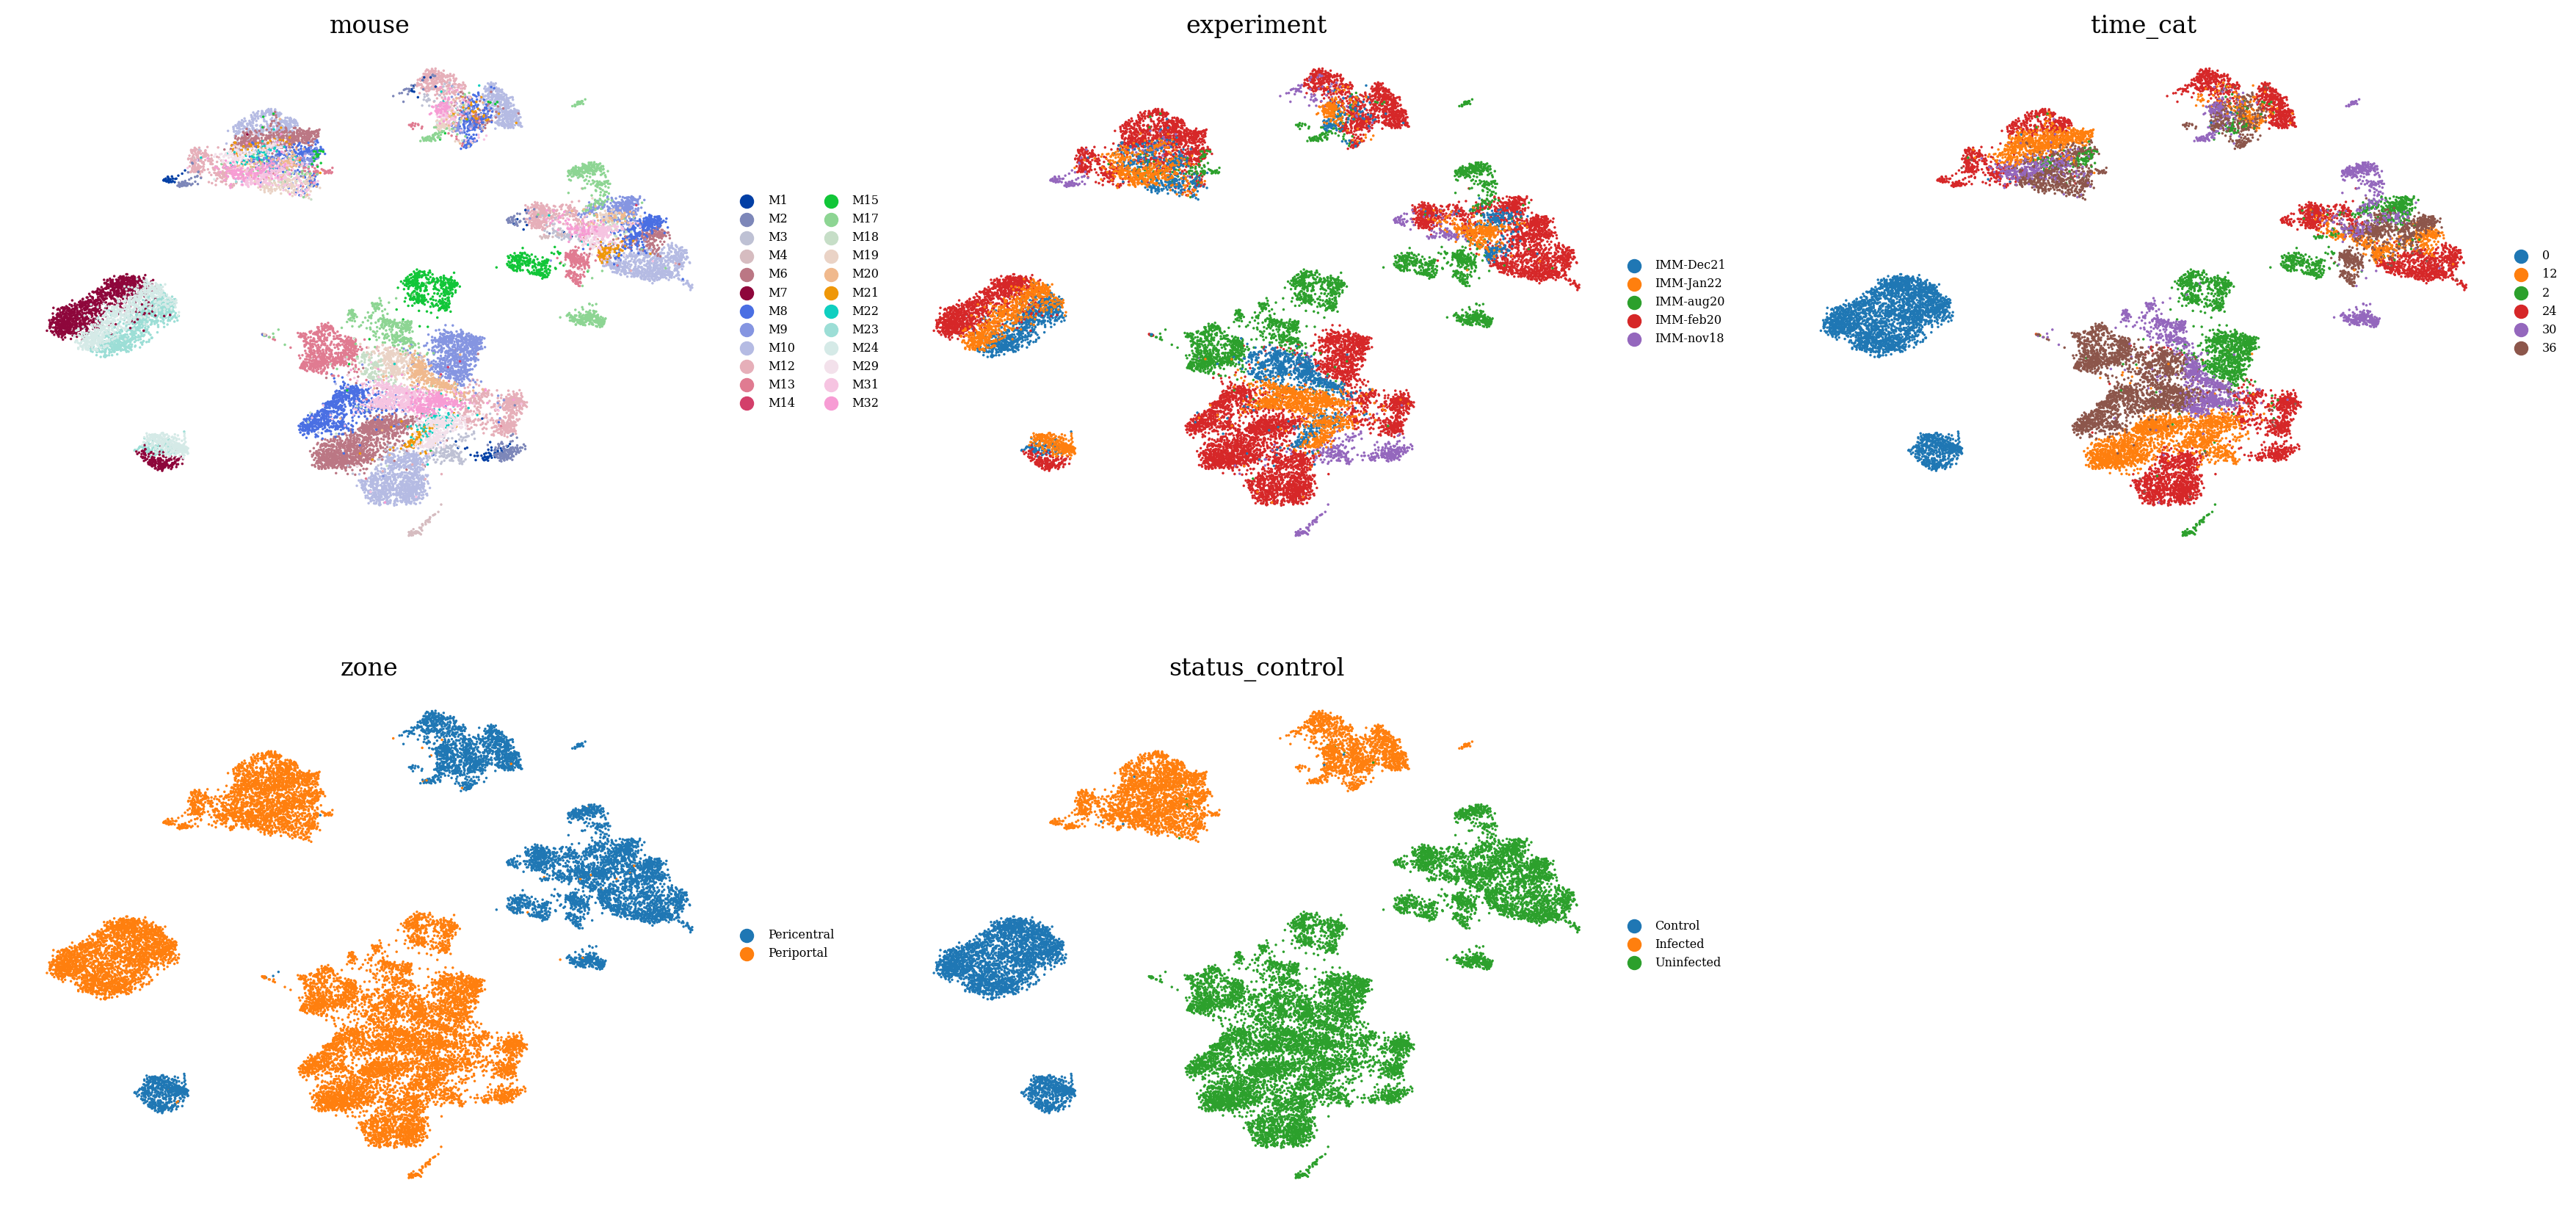

In [18]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

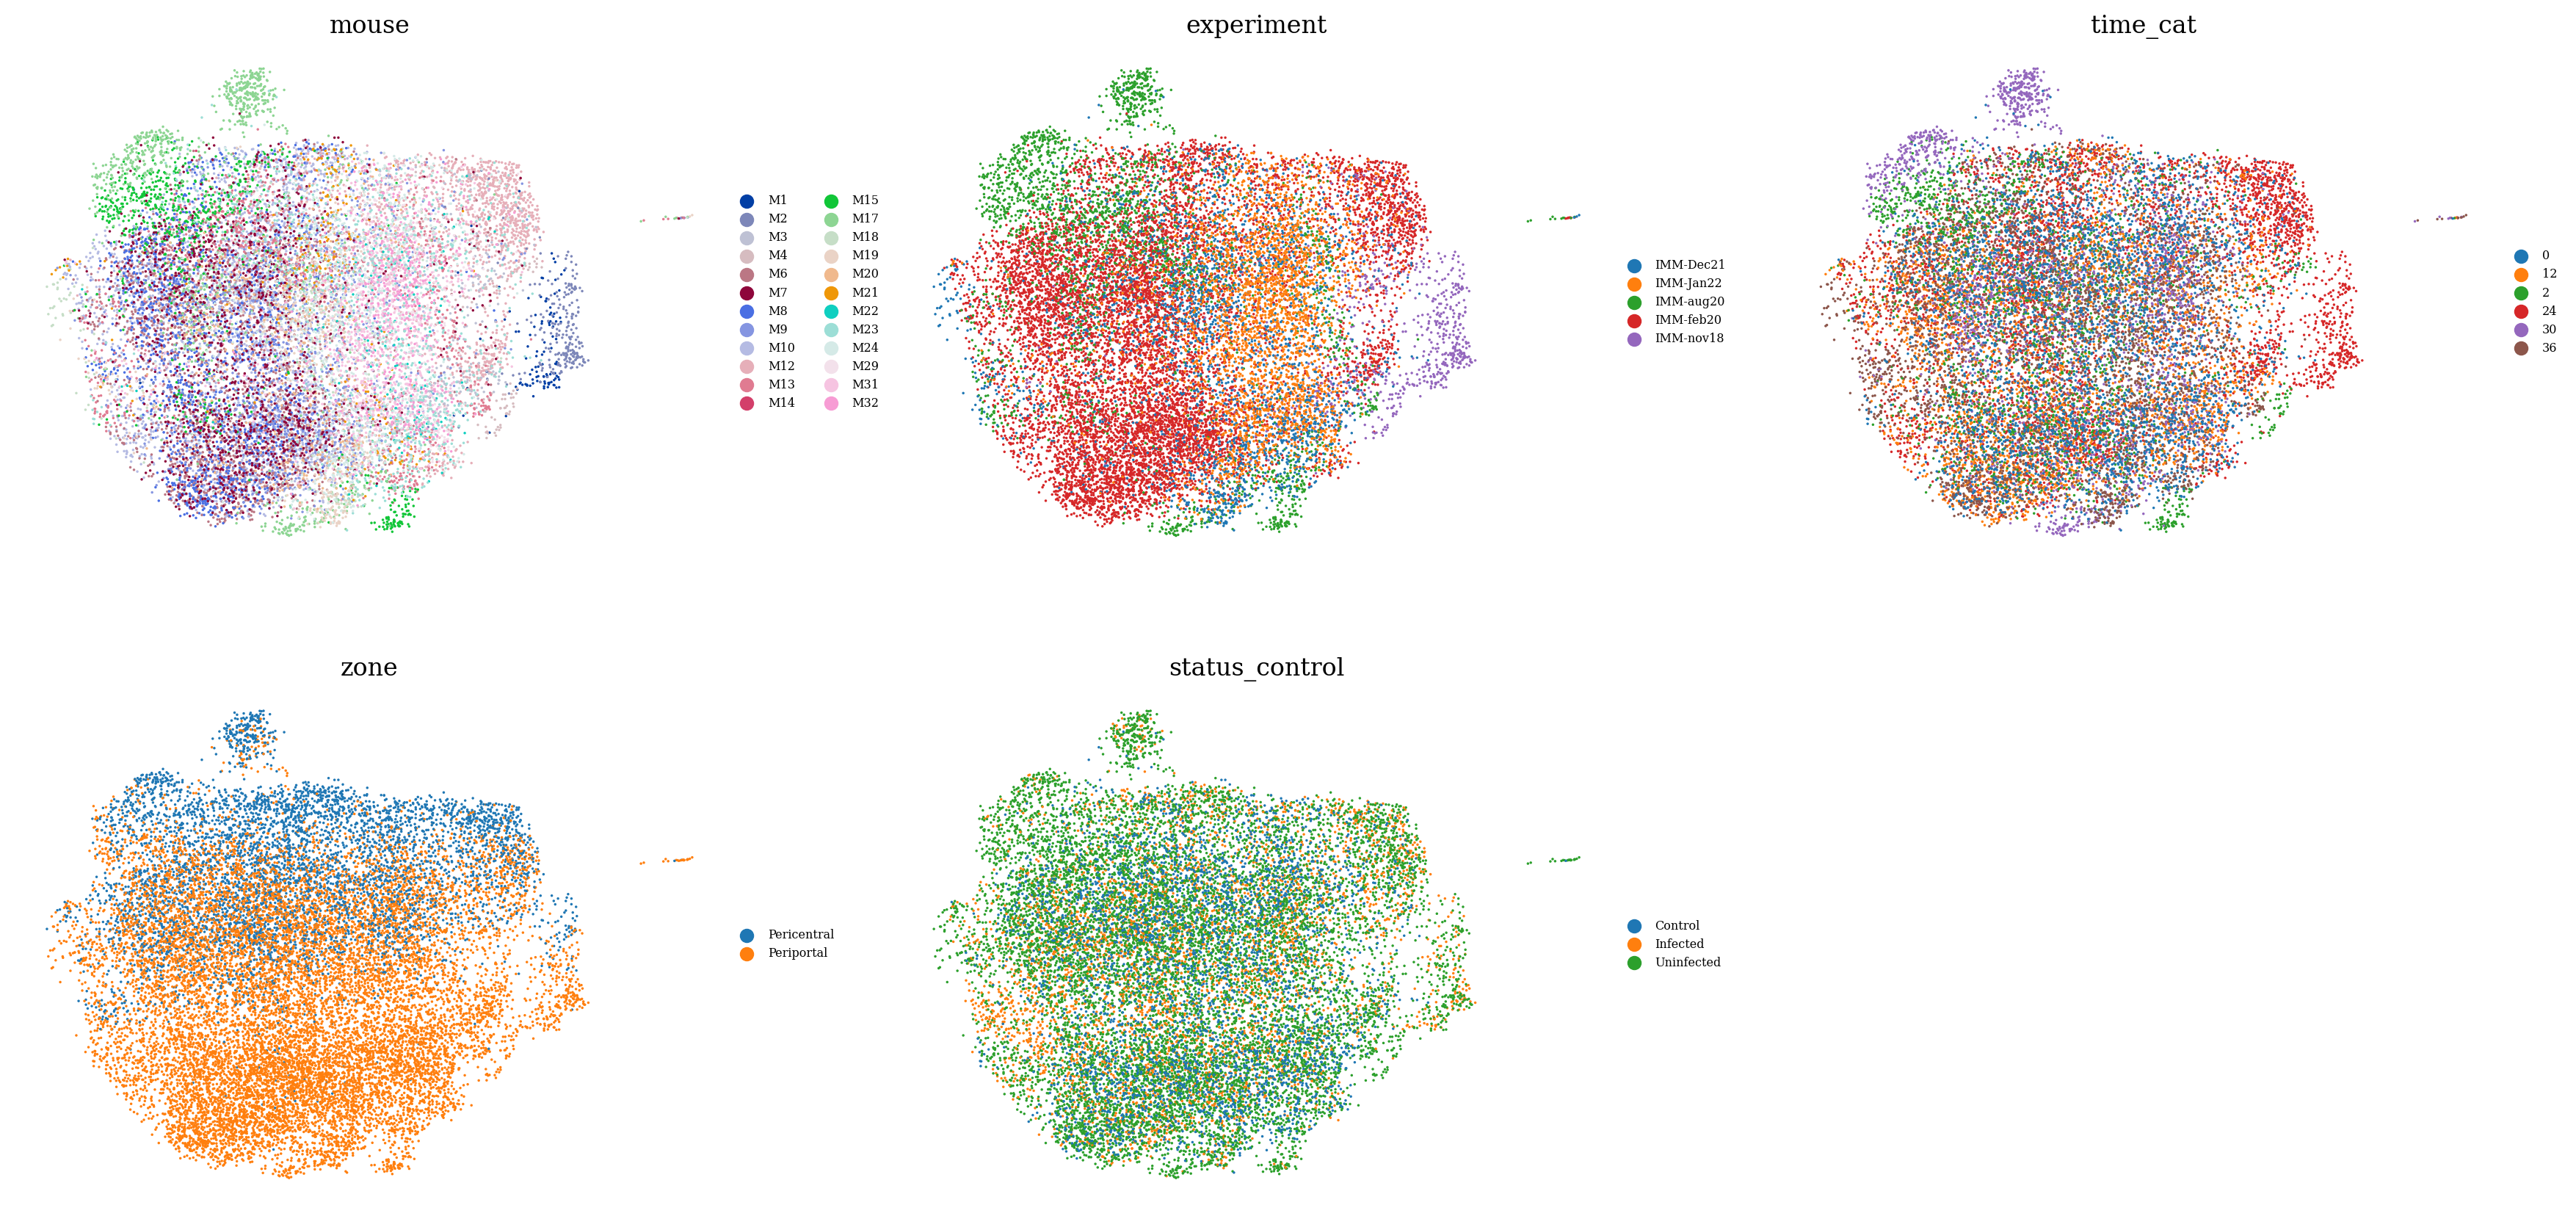

In [19]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [20]:
model.predict()

  0%|          | 0/596 [00:00<?, ?it/s]

  1%|          | 3/596 [00:00<00:19, 29.93it/s]

  5%|▍         | 27/596 [00:00<00:03, 151.29it/s]

  9%|▊         | 51/596 [00:00<00:02, 190.28it/s]

 13%|█▎        | 75/596 [00:00<00:02, 209.01it/s]

 17%|█▋        | 99/596 [00:00<00:02, 219.02it/s]

 20%|██        | 122/596 [00:00<00:02, 222.62it/s]

 24%|██▍       | 145/596 [00:00<00:02, 224.28it/s]

 28%|██▊       | 168/596 [00:00<00:01, 225.89it/s]

 32%|███▏      | 191/596 [00:00<00:01, 227.08it/s]

 36%|███▌      | 215/596 [00:01<00:01, 228.07it/s]

 40%|███▉      | 238/596 [00:01<00:01, 227.40it/s]

 44%|████▍     | 261/596 [00:01<00:01, 227.86it/s]

 48%|████▊     | 284/596 [00:01<00:01, 227.98it/s]

 52%|█████▏    | 307/596 [00:01<00:01, 228.29it/s]

 55%|█████▌    | 330/596 [00:01<00:01, 228.14it/s]

 59%|█████▉    | 353/596 [00:01<00:01, 228.44it/s]

 63%|██████▎   | 377/596 [00:01<00:00, 228.95it/s]

 67%|██████▋   | 400/596 [00:01<00:00, 229.03it/s]

 71%|███████   | 423/596 [00:01<00:00, 228.70it/s]

 75%|███████▍  | 446/596 [00:02<00:00, 227.57it/s]

 79%|███████▊  | 469/596 [00:02<00:00, 228.04it/s]

 83%|████████▎ | 492/596 [00:02<00:00, 224.49it/s]

 86%|████████▋ | 515/596 [00:02<00:00, 225.54it/s]

 90%|█████████ | 538/596 [00:02<00:00, 221.72it/s]

 94%|█████████▍| 561/596 [00:02<00:00, 223.55it/s]

 98%|█████████▊| 584/596 [00:02<00:00, 218.27it/s]

100%|██████████| 596/596 [00:03<00:00, 192.63it/s]

In [21]:
pred_adata = adata[model.test_indices]
true = np.array(pred_adata.X)
pred = np.array(pred_adata.obsm["CPA_pred"])

In [22]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    print(start_ind, end_ind)
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind


0

32

32

64

64

96

96

128

128

160

160

192

192

224

224

256

256

288

288

320

320

352

352

384

384

416

416

448

448

480

480

512

512

544

544

576

576

608

608

640

640

672

672

704

704

736

736

768

768

800

800

832

832

864

864

896

896

928

928

960

960

992

992

1024

1024

1056

1056

1088

In [23]:
np.mean(r2s)

0.978840375792305

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)